In [1]:
import warnings
warnings.filterwarnings("ignore")


## ANOMALY DETECTION and TIME SERIES ANALYSIS

In [5]:
# Removing and preparing the original dataset

import pandas as pd

def process_engine(engine_file):

    df = pd.read_csv(engine_file, skiprows=3, usecols=lambda column: column not in [0, 1])

    desired_columns = ["table", "_time", "_value", "_field"]
    df_extracted = df[desired_columns]

    df_extracted = df_extracted.pivot(index="_time",
                                      columns='_field', values='_value').reset_index()

    df_extracted.fillna(0, inplace=True)

    df_extracted.columns.name = None
    df_extracted.rename(columns=lambda col: col.replace('_field_', ''), inplace=True)

    print(df_extracted)

    df_extracted['_time'] = pd.to_datetime(df_extracted['_time'])
    df_extracted.sort_values(by='_time', inplace=True)

    df_extracted['hour'] = df_extracted['_time'].dt.hour

    resampled_file_name = 'modified_' + engine_file.split('/')[-1]
    df_extracted.to_csv(resampled_file_name, index=False)


# Process the first engine
engine1 = '/content/sb_main_engine.csv'
process_engine(engine1)

# Process the second engine
engine2 = '/content/ps_main_engine.csv'
process_engine(engine2)


                        _time  Acc. Pedal Position  Air Filter Diff Press.  \
0     2023-05-01T10:42:32.44Z             0.000000                0.000000   
1    2023-05-01T16:50:32.442Z             0.000000                0.000000   
2    2023-05-01T22:58:32.444Z             5.167123                0.108904   
3    2023-05-02T05:06:32.446Z             9.427027                0.258784   
4    2023-05-02T11:14:32.448Z             0.657534                0.007534   
..                        ...                  ...                     ...   
346  2023-07-29T02:58:33.134Z             2.575342                0.026712   
347  2023-07-29T09:06:33.136Z            31.340541                0.378378   
348  2023-07-29T15:14:33.138Z            27.479452                0.341781   
349   2023-07-29T21:22:33.14Z            39.935135                0.469595   
350  2023-07-30T03:30:33.142Z            30.823529                0.351471   

     Air Inlet Press.  Auxiliary Press. 1  Barometric Press.  B

In [6]:
# Choose any sensor from the above list for the rest of the analysis

engine1 = '/content/modified_sb_main_engine.csv'
engine2 = '/content/modified_ps_main_engine.csv'
df1 = pd.read_csv(engine1)
df2 = pd.read_csv(engine2)
df1.info()
df2.info()
sensor = 'Acc. Pedal Position'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 69 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   _time                             351 non-null    object 
 1   Acc. Pedal Position               351 non-null    float64
 2   Air Filter Diff Press.            351 non-null    float64
 3   Air Inlet Press.                  351 non-null    float64
 4   Auxiliary Press. 1                351 non-null    float64
 5   Barometric Press.                 351 non-null    float64
 6   Boost Press.                      351 non-null    float64
 7   Coolant Level                     351 non-null    float64
 8   Coolant Press.                    351 non-null    float64
 9   Coolant Temp.                     351 non-null    float64
 10  Crankcase Press.                  351 non-null    float64
 11  Electrical Voltage                351 non-null    float64
 12  Eng. Aux

<Axes: xlabel='hour'>

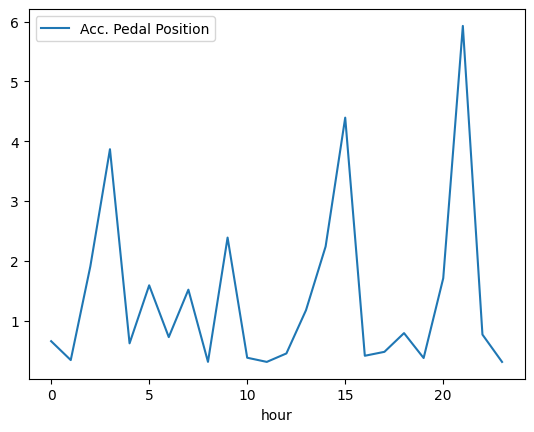

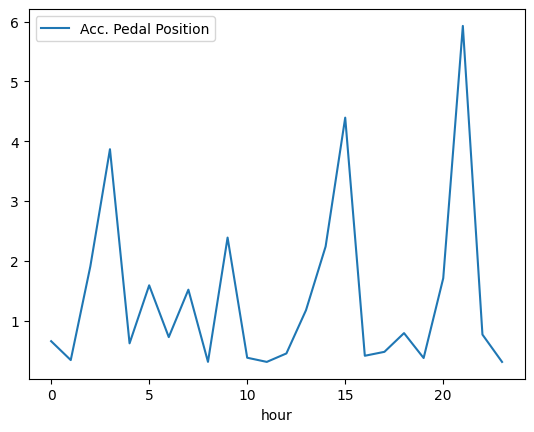

In [9]:
# Hourly plot of the sensors performance
df1[[sensor,'hour']].groupby('hour').mean().plot()
df2[[sensor,'hour']].groupby('hour').mean().plot()

In [8]:
#  Date performance of the sensor
import plotly.express as px
fig1 = px.line(df1.reset_index(), x= '_time', y = sensor , title = sensor+' engine1')
fig1.update_xaxes(rangeslider_visible = True,)
fig2 = px.line(df1.reset_index(), x= '_time', y = sensor , title = sensor+' engine2')
fig2.update_xaxes(rangeslider_visible = True,)
fig1.show()
fig2.show()


In [10]:
# IsolationForest model for detecting anomalies
from sklearn.ensemble import IsolationForest
import joblib
desired_columns = ["_time", sensor, "hour"]
df1 = df1[desired_columns]

model = IsolationForest(contamination = 0.02)
model.fit(df1[[sensor]])
filename = 'isolation_forest_model1.pkl'
joblib.dump(model, filename)

desired_columns = ["_time", sensor, "hour"]
df2 = df2[desired_columns]

model = IsolationForest(contamination = 0.02)
model.fit(df2[[sensor]])
filename = 'isolation_forest_model2.pkl'
joblib.dump(model, filename)

['isolation_forest_model2.pkl']

In [11]:
# adding a new column for yes,no anomaly
df1['anom'] = pd.Series(model.predict(df1[[sensor]])).apply(lambda x: 'yes' if (x == -1) else 'no')
df2['anom'] = pd.Series(model.predict(df2[[sensor]])).apply(lambda x: 'yes' if (x == -1) else 'no')

In [12]:
# query to get those anomalies
df1.query('anom == "yes"')
df2.query('anom == "yes"')

_time  Acc. Pedal Position  hour anom
120  2023-06-01 02:42:32.680000+00:00            18.616216     2  yes
259  2023-07-06 21:22:32.960000+00:00            42.767568    21  yes
344  2023-07-28 14:42:33.130000+00:00            18.594595    14  yes
347  2023-07-29 09:06:33.136000+00:00            31.340541     9  yes
348  2023-07-29 15:14:33.138000+00:00            27.479452    15  yes
349  2023-07-29 21:22:33.140000+00:00            39.935135    21  yes
350  2023-07-30 03:30:33.142000+00:00            30.823529     3  yes

In [13]:
# the plot of the normal data of sensor with showing anomalies
fig1 = px.scatter(df1.reset_index(), x = '_time', y = sensor, color = 'anom', hover_data= ['hour'], title = sensor)
fig1.update_xaxes(rangeslider_visible = True,)
fig2 = px.scatter(df2.reset_index(), x = '_time', y = sensor, color = 'anom', hover_data= ['hour'], title = sensor)
fig2.update_xaxes(rangeslider_visible = True,)
fig1.show()
fig2.show()

## PREDICTION

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [15]:
df = pd.read_csv('/content/modified_sb_main_engine.csv')
df = df.set_index('_time')
df.index = pd.to_datetime(df.index)

In [16]:
df.tail()

Acc. Pedal Position  Air Filter Diff Press.  \
_time                                                                           
2023-07-29 02:58:33.134000+00:00             2.575342                0.026712   
2023-07-29 09:06:33.136000+00:00            31.340541                0.378378   
2023-07-29 15:14:33.138000+00:00            27.479452                0.341781   
2023-07-29 21:22:33.140000+00:00            39.935135                0.469595   
2023-07-30 03:30:33.142000+00:00            30.823529                0.351471   

                                  Air Inlet Press.  Auxiliary Press. 1  \
_time                                                                    
2023-07-29 02:58:33.134000+00:00               0.0                 0.0   
2023-07-29 09:06:33.136000+00:00               0.0                 0.0   
2023-07-29 15:14:33.138000+00:00               0.0                 0.0   
2023-07-29 21:22:33.140000+00:00               0.0                 0.0   
2023-07-30 03:30:33.142000+00:00               0.0                 0.0   

                                  Barometric Press.  Boost Press.  \
_time                                                               
2023-07-29 02:58:33.134000+00:00                0.0      0.767123   
2023-07-29 09:06:33.136000+00:00                0.0      9.540541   
2023-07-29 15:14:33.138000+00:00                0.0      7.479452   
2023-07-29 21:22:33.140000+00:00                0.0     21.756757   
2023-07-30 03:30:33.142000+00:00                0.0      9.411765   

                                  Coolant Level  Coolant Press.  \
_time                                                             
2023-07-29 02:58:33.134000+00:00            0.0             0.0   
2023-07-29 09:06:33.136000+00:00            0.0             0.0   
2023-07-29 15:14:33.138000+00:00            0.0             0.0   
2023-07-29 21:22:33.140000+00:00            0.0             0.0   
2023-07-30 03:30:33.142000+00:00            0.0             0.0   

                                  Coolant Temp.  Crankcase Press.   ...  \
_time                                                               ...   
2023-07-29 02:58:33.134000+00:00      53.547945           0.006877  ...   
2023-07-29 09:06:33.136000+00:00      77.972973           0.006554  ...   
2023-07-29 15:14:33.138000+00:00      77.589041           0.000219  ...   
2023-07-29 21:22:33.140000+00:00      78.162162           0.000108  ...   
2023-07-30 03:30:33.142000+00:00      77.147059           0.000000  ...   

                                  Total Idle Fuel   Total Idle Operation   \
_time                                                                       
2023-07-29 02:58:33.134000+00:00      60641.917808             125.800959   
2023-07-29 09:06:33.136000+00:00      60648.500000             125.815000   
2023-07-29 15:14:33.138000+00:00      60649.267123             125.816575   
2023-07-29 21:22:33.140000+00:00      60675.939189             125.869932   
2023-07-30 03:30:33.142000+00:00      60676.000000             125.870000   

                                  Transmission Oil Press.   \
_time                                                        
2023-07-29 02:58:33.134000+00:00                       0.0   
2023-07-29 09:06:33.136000+00:00                       0.0   
2023-07-29 15:14:33.138000+00:00                       0.0   
2023-07-29 21:22:33.140000+00:00                       0.0   
2023-07-30 03:30:33.142000+00:00                       0.0   

                                  Transmission Oil Temp.   \
_time                                                       
2023-07-29 02:58:33.134000+00:00                      0.0   
2023-07-29 09:06:33.136000+00:00                      0.0   
2023-07-29 15:14:33.138000+00:00                      0.0   
2023-07-29 21:22:33.140000+00:00                      0.0   
2023-07-30 03:30:33.142000+00:00                      0.0   

                                  Transmission Output Sharp Spee

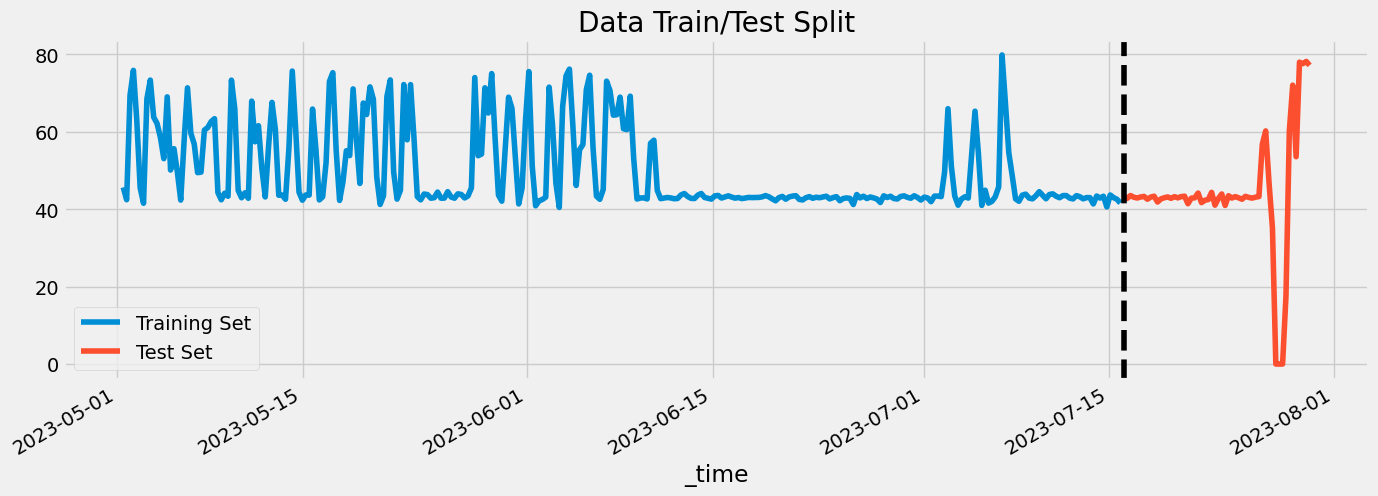

In [17]:
# Select a sensor for the analysis and prediction
sensor = 'Coolant Temp.'
desired_column = sensor

train = df.loc[df.index < '2023-07-16 02:10:33.032000+00:00']
test = df.loc[df.index >= '2023-07-16 02:10:33.032000+00:00']

fig, ax = plt.subplots(figsize=(15, 5))
train[desired_column].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test[desired_column].plot(ax=ax, label='Test Set')
ax.axvline('2023-07-16 02:10:33.032000+00:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [18]:
# creating features of hour and day for the predicition
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['day'] = df.index.day
    return df

df = create_features(df)

In [19]:
df.tail()

Acc. Pedal Position  Air Filter Diff Press.  \
_time                                                                           
2023-07-29 02:58:33.134000+00:00             2.575342                0.026712   
2023-07-29 09:06:33.136000+00:00            31.340541                0.378378   
2023-07-29 15:14:33.138000+00:00            27.479452                0.341781   
2023-07-29 21:22:33.140000+00:00            39.935135                0.469595   
2023-07-30 03:30:33.142000+00:00            30.823529                0.351471   

                                  Air Inlet Press.  Auxiliary Press. 1  \
_time                                                                    
2023-07-29 02:58:33.134000+00:00               0.0                 0.0   
2023-07-29 09:06:33.136000+00:00               0.0                 0.0   
2023-07-29 15:14:33.138000+00:00               0.0                 0.0   
2023-07-29 21:22:33.140000+00:00               0.0                 0.0   
2023-07-30 03:30:33.142000+00:00               0.0                 0.0   

                                  Barometric Press.  Boost Press.  \
_time                                                               
2023-07-29 02:58:33.134000+00:00                0.0      0.767123   
2023-07-29 09:06:33.136000+00:00                0.0      9.540541   
2023-07-29 15:14:33.138000+00:00                0.0      7.479452   
2023-07-29 21:22:33.140000+00:00                0.0     21.756757   
2023-07-30 03:30:33.142000+00:00                0.0      9.411765   

                                  Coolant Level  Coolant Press.  \
_time                                                             
2023-07-29 02:58:33.134000+00:00            0.0             0.0   
2023-07-29 09:06:33.136000+00:00            0.0             0.0   
2023-07-29 15:14:33.138000+00:00            0.0             0.0   
2023-07-29 21:22:33.140000+00:00            0.0             0.0   
2023-07-30 03:30:33.142000+00:00            0.0             0.0   

                                  Coolant Temp.  Crankcase Press.   ...  \
_time                                                               ...   
2023-07-29 02:58:33.134000+00:00      53.547945           0.006877  ...   
2023-07-29 09:06:33.136000+00:00      77.972973           0.006554  ...   
2023-07-29 15:14:33.138000+00:00      77.589041           0.000219  ...   
2023-07-29 21:22:33.140000+00:00      78.162162           0.000108  ...   
2023-07-30 03:30:33.142000+00:00      77.147059           0.000000  ...   

                                  Total Idle Operation   \
_time                                                     
2023-07-29 02:58:33.134000+00:00             125.800959   
2023-07-29 09:06:33.136000+00:00             125.815000   
2023-07-29 15:14:33.138000+00:00             125.816575   
2023-07-29 21:22:33.140000+00:00             125.869932   
2023-07-30 03:30:33.142000+00:00             125.870000   

                                  Transmission Oil Press.   \
_time                                                        
2023-07-29 02:58:33.134000+00:00                       0.0   
2023-07-29 09:06:33.136000+00:00                       0.0   
2023-07-29 15:14:33.138000+00:00                       0.0   
2023-07-29 21:22:33.140000+00:00                       0.0   
2023-07-30 03:30:33.142000+00:00                       0.0   

                                  Transmission Oil Temp.   \
_time                                                       
2023-07-29 02:58:33.134000+00:00                      0.0   
2023-07-29 09:06:33.136000+00:00                      0.0   
2023-07-29 15:14:33.138000+00:00                      0.0   
2023-07-29 21:22:33.140000+00:00                      0.0   
2023-07-30 03:30:33.142000+00:00                      0.0   

                                  Transmission Output Sharp Speed   \
_time                                                                
2023-07-29 02:58:33.134000+00:00                  

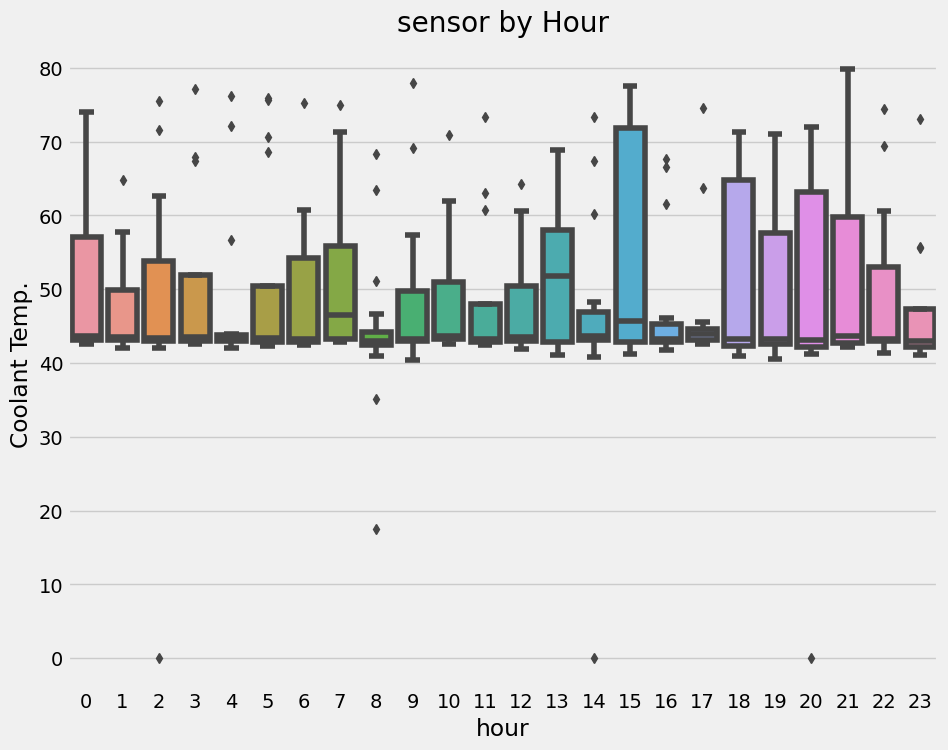

In [20]:
# hourly performance of sensor
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y= sensor)
ax.set_title('sensor by Hour')
plt.show()

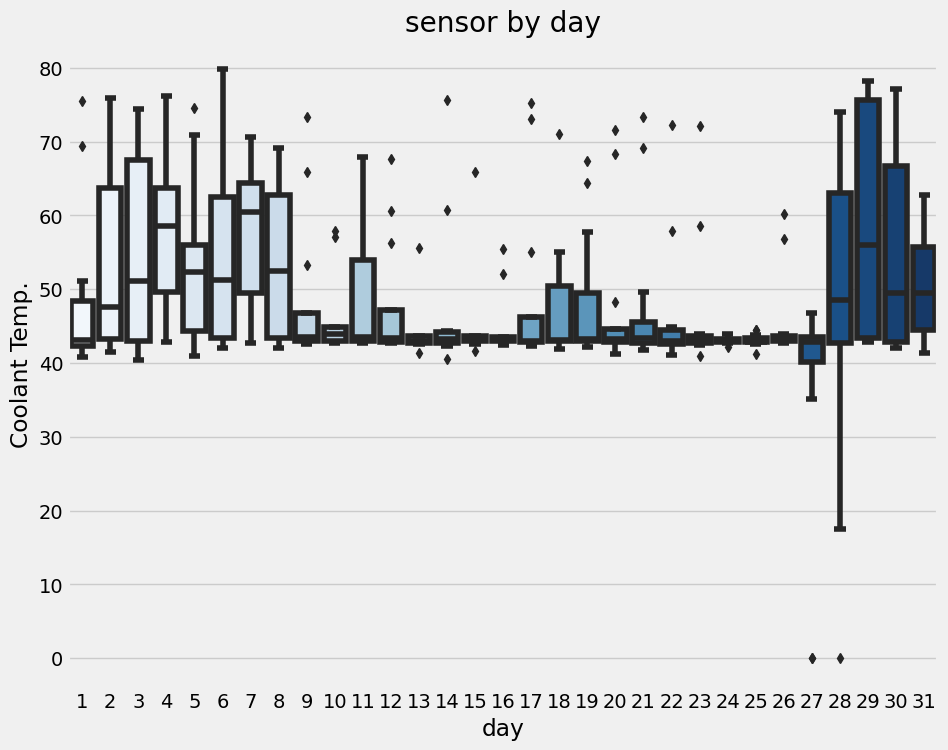

In [21]:
# daily performance of the sensor
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='day', y= sensor, palette='Blues')
ax.set_title('sensor by day')
plt.show()

In [22]:
# Setting the train and test data
train = create_features(train)
test = create_features(test)

FEATURES = ['day', 'hour']
TARGET = sensor

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [23]:
# XGBOOST TRAINING FOR LEARING FORECASTING
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[08:09:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:50.01659	validation_1-rmse:45.73401
[100]	validation_0-rmse:20.64989	validation_1-rmse:20.25034
[200]	validation_0-rmse:11.79598	validation_1-rmse:14.91235
[285]	validation_0-rmse:9.94020	validation_1-rmse:14.76843


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

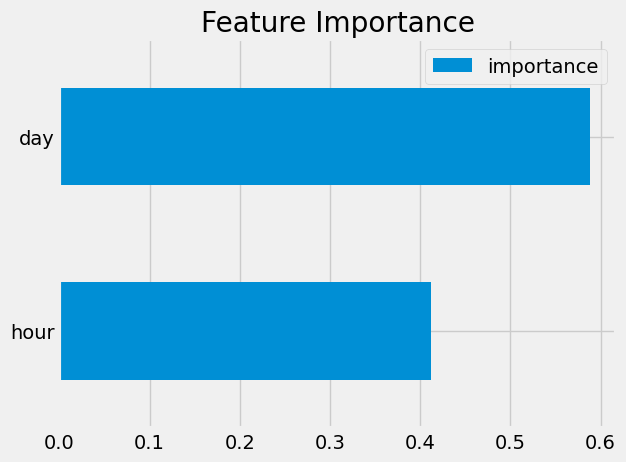

In [24]:
# Hourly vs daily
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

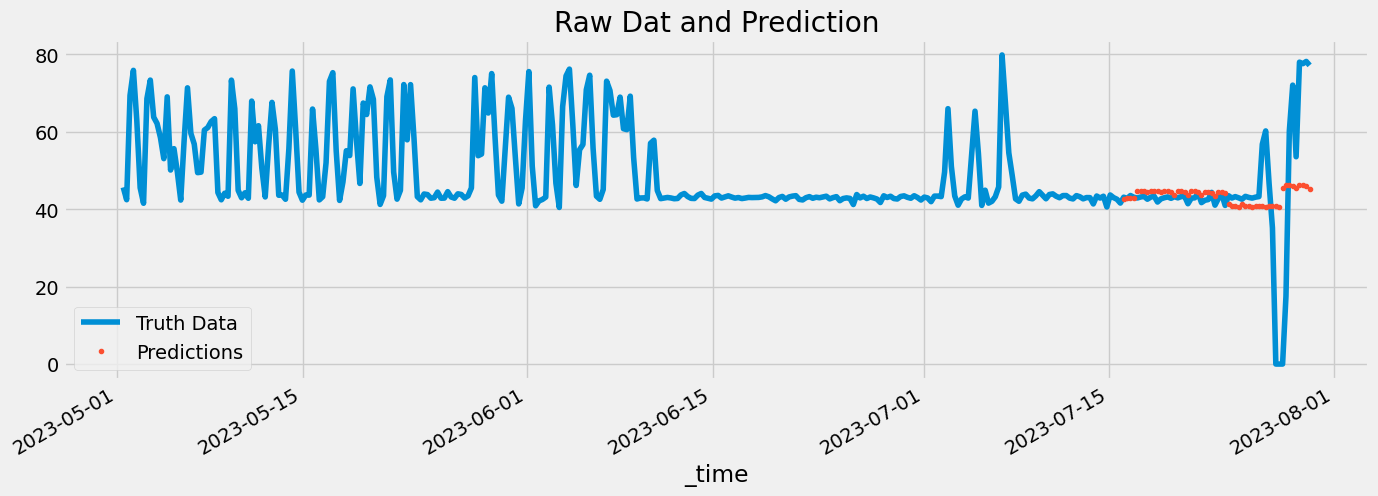

In [25]:
# how accurate are the predictions
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[[sensor]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [26]:
# Score of prediction
score = np.sqrt(mean_squared_error(test[sensor], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 14.65


In [27]:
# which timestamps are errored
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-07-30    32.001784
2023-07-28    28.528919
2023-07-29    25.797990
2023-07-27    23.242968
2023-07-26    10.080718
2023-07-24     2.254527
2023-07-25     2.066865
2023-07-18     1.970640
2023-07-17     1.735773
2023-07-20     1.717541
Name: error, dtype: float64

## MONITORING

In [28]:
# this code will find the anomalies of all of the sensors attached to the machhine
import pandas as pd
from sklearn.ensemble import IsolationForest
import joblib

def detect_anomalies(sensor, df, contamination=0.04):
    desired_columns = ["_time", sensor, "hour"]
    df = df[desired_columns]

    model = IsolationForest(contamination=contamination)
    model.fit(df[[sensor]])

    predictions = model.predict(df[[sensor]])

    df['Anomaly'] = predictions

    return df[df['Anomaly'] == -1]

engine1 = '/content/modified_sb_main_engine.csv'
engine2 = '/content/modified_ps_main_engine.csv'


df1 = pd.read_csv(engine1)
df2 = pd.read_csv(engine2)


all_columns = df1.columns.tolist()
all_columns.remove("_time")
all_columns.remove("hour")

anomaly_points = {}


for sensor in all_columns:
    anomaly_points[sensor] = detect_anomalies(sensor, df1)

for sensor, anomalies in anomaly_points.items():
    print(f"Anomaly points for {sensor}:")
    print(anomalies)



Anomaly points for Acc. Pedal Position:
                                _time  Acc. Pedal Position  hour  Anomaly
3    2023-05-02 05:06:32.446000+00:00             9.427027     5       -1
32   2023-05-09 14:58:32.504000+00:00            10.290411    14       -1
38   2023-05-11 03:46:32.516000+00:00             8.351351     3       -1
50   2023-05-14 05:22:32.540000+00:00             8.870270     5       -1
104  2023-05-28 00:34:32.648000+00:00             6.690411     0       -1
120  2023-06-01 02:42:32.680000+00:00            18.616216     2       -1
132  2023-06-04 04:18:32.704000+00:00             6.175342     4       -1
259  2023-07-06 21:22:32.960000+00:00            42.767568    21       -1
344  2023-07-28 14:42:33.130000+00:00            18.594595    14       -1
345  2023-07-28 20:50:33.132000+00:00            11.340541    20       -1
347  2023-07-29 09:06:33.136000+00:00            31.340541     9       -1
348  2023-07-29 15:14:33.138000+00:00            27.479452    15       -

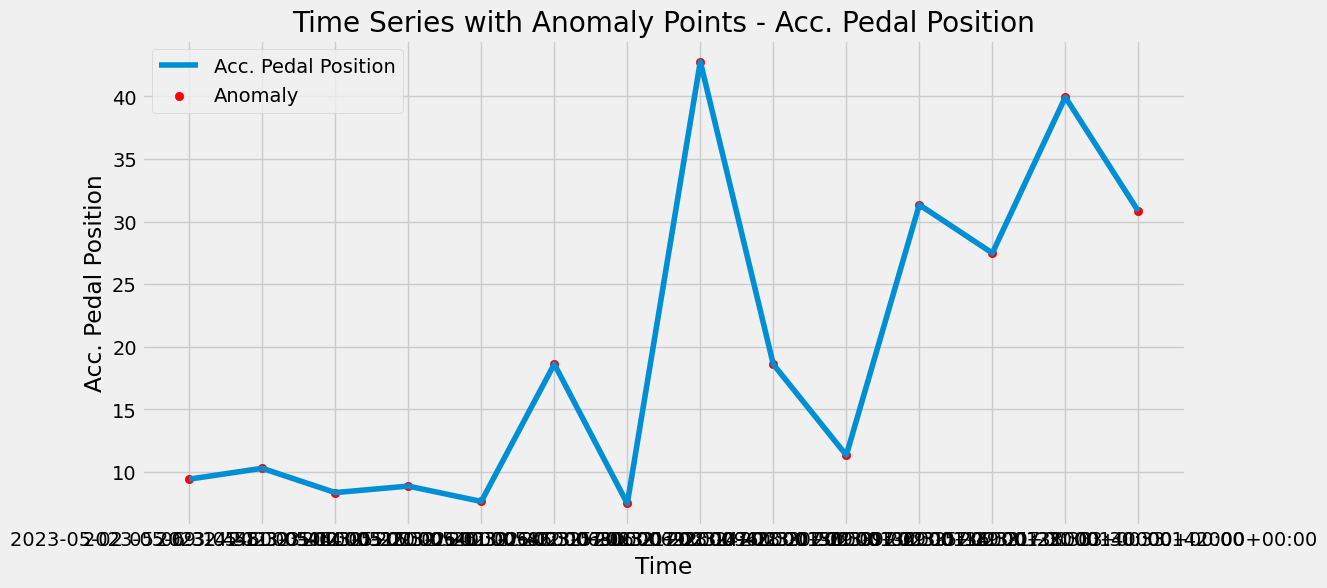

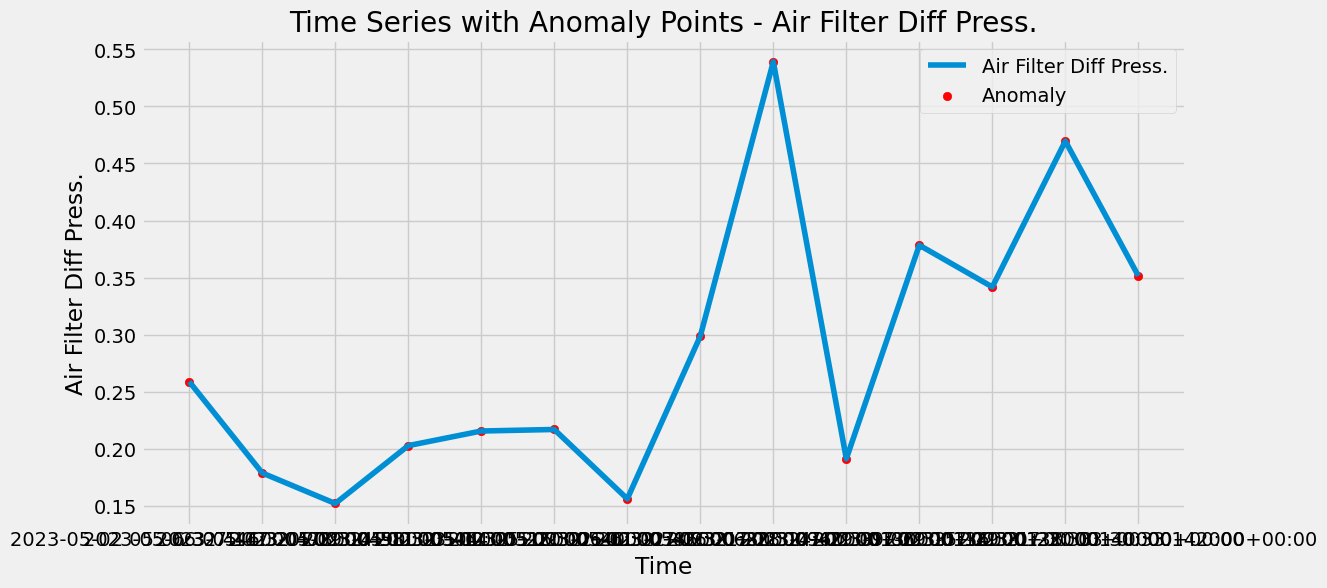

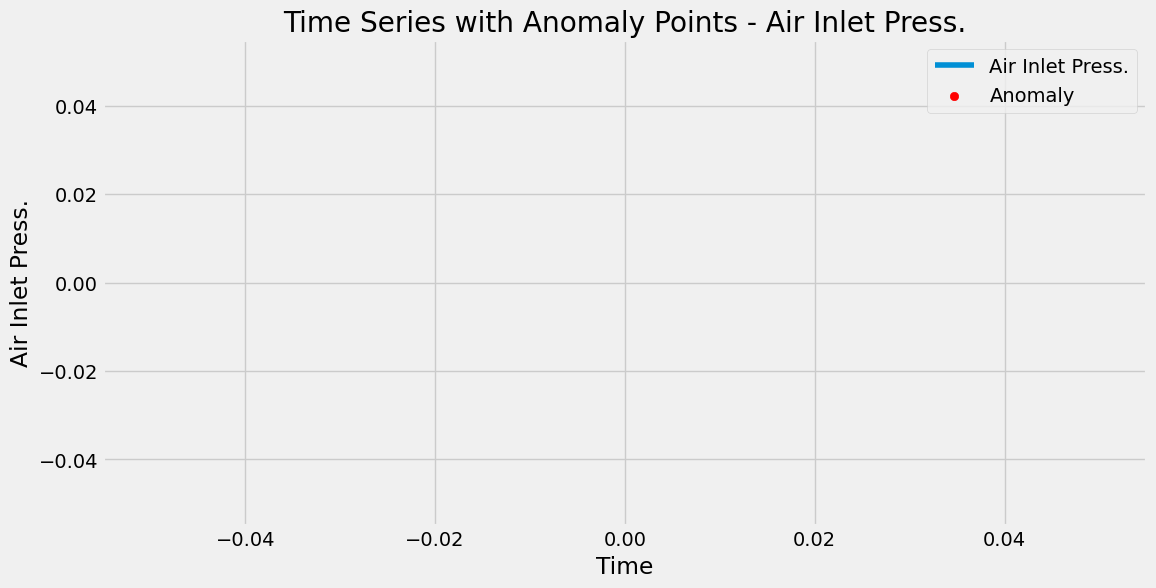

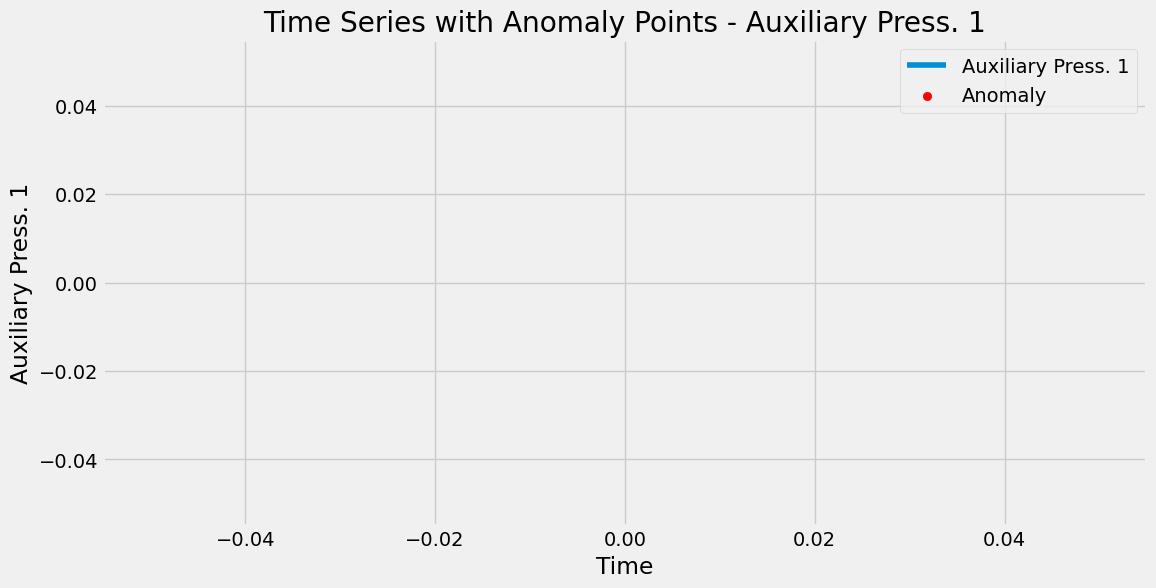

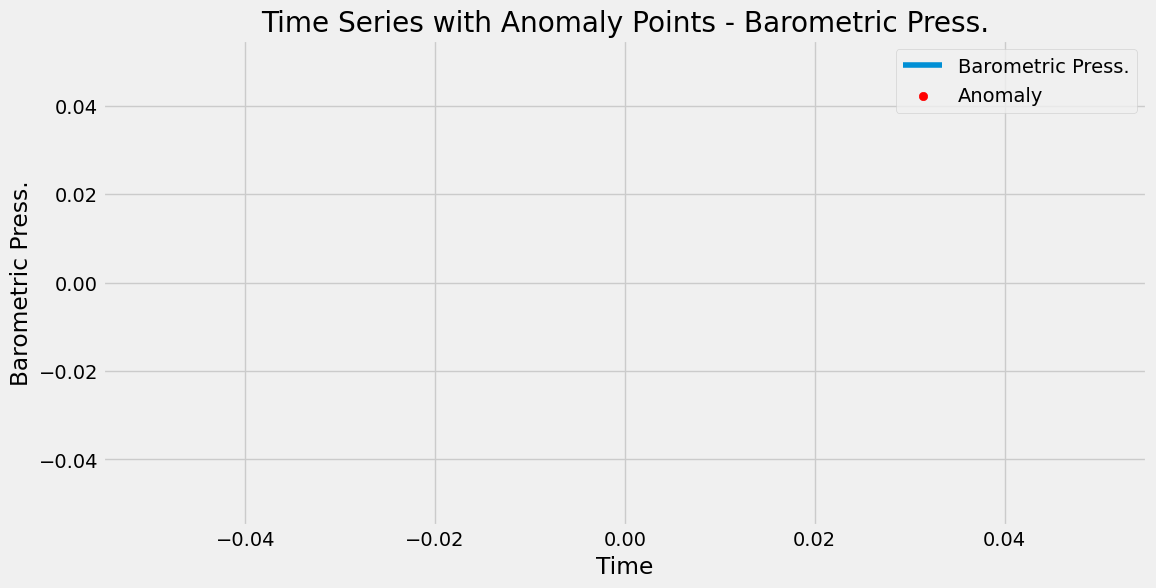

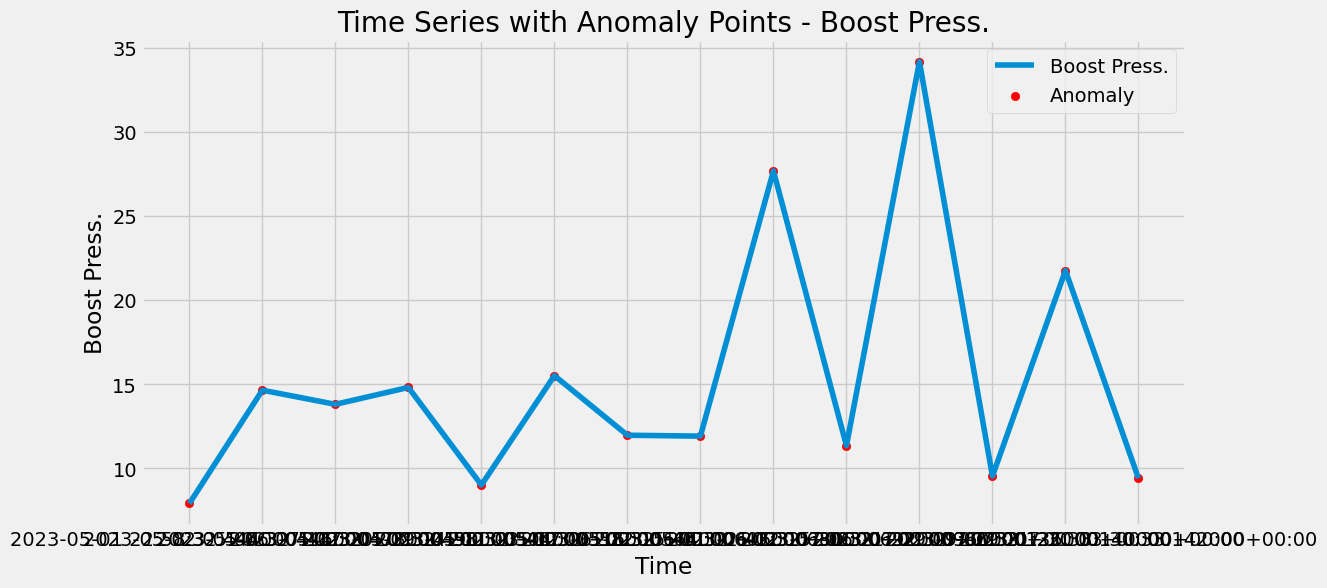

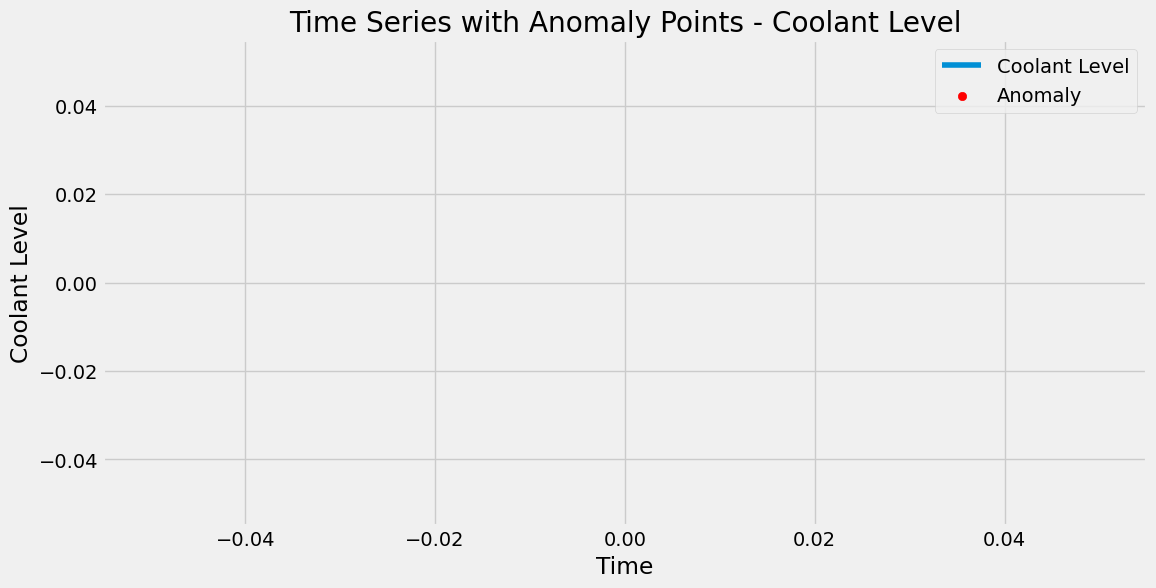

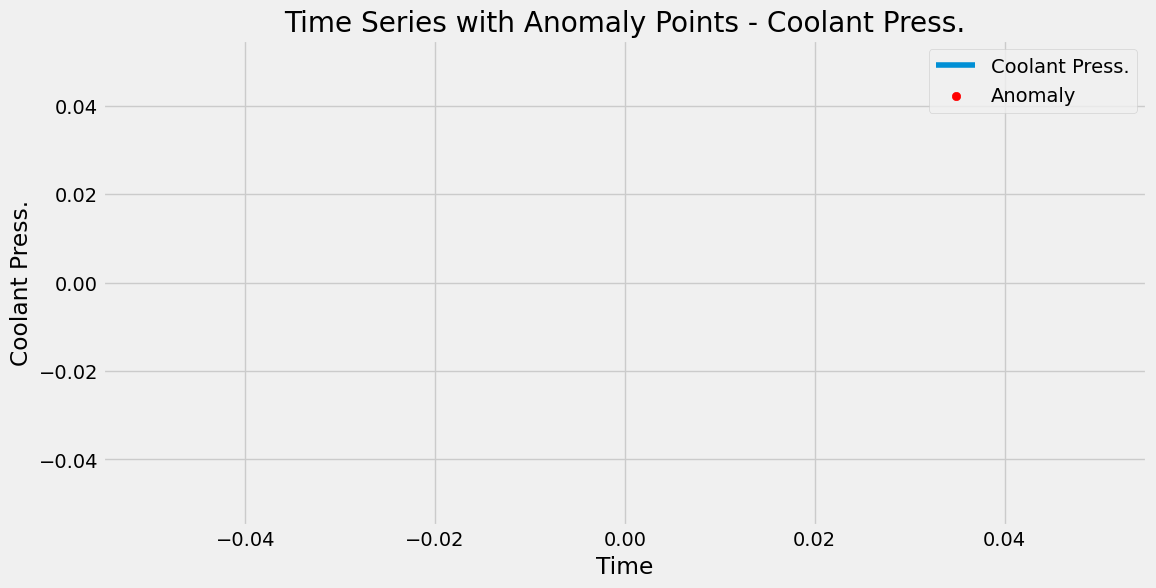

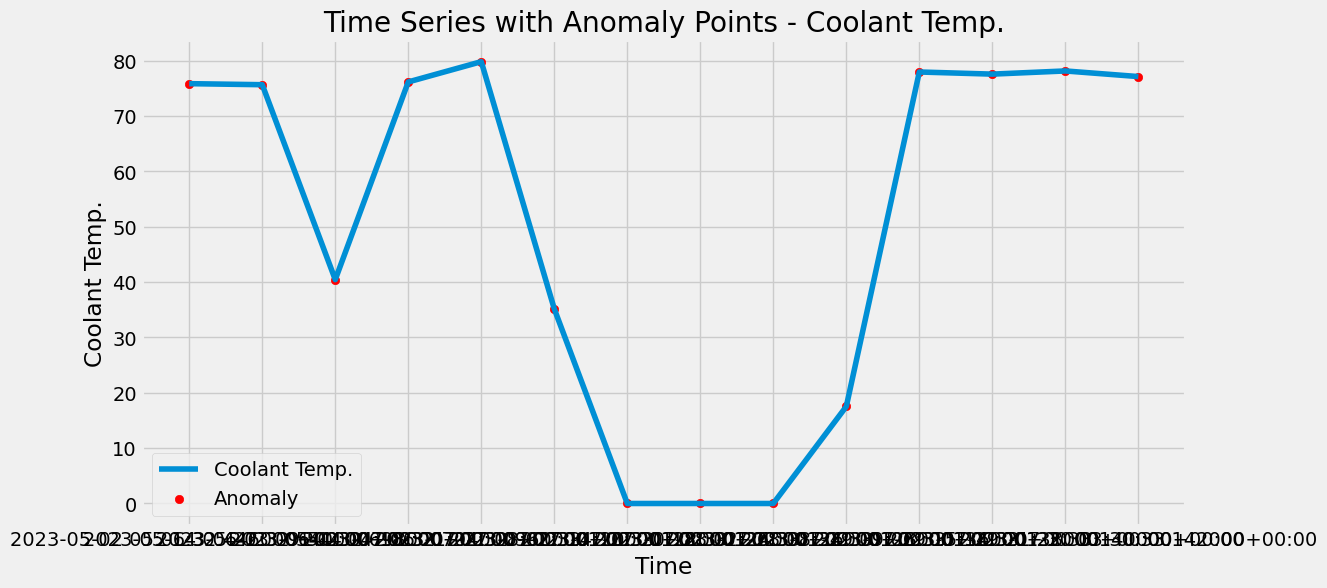

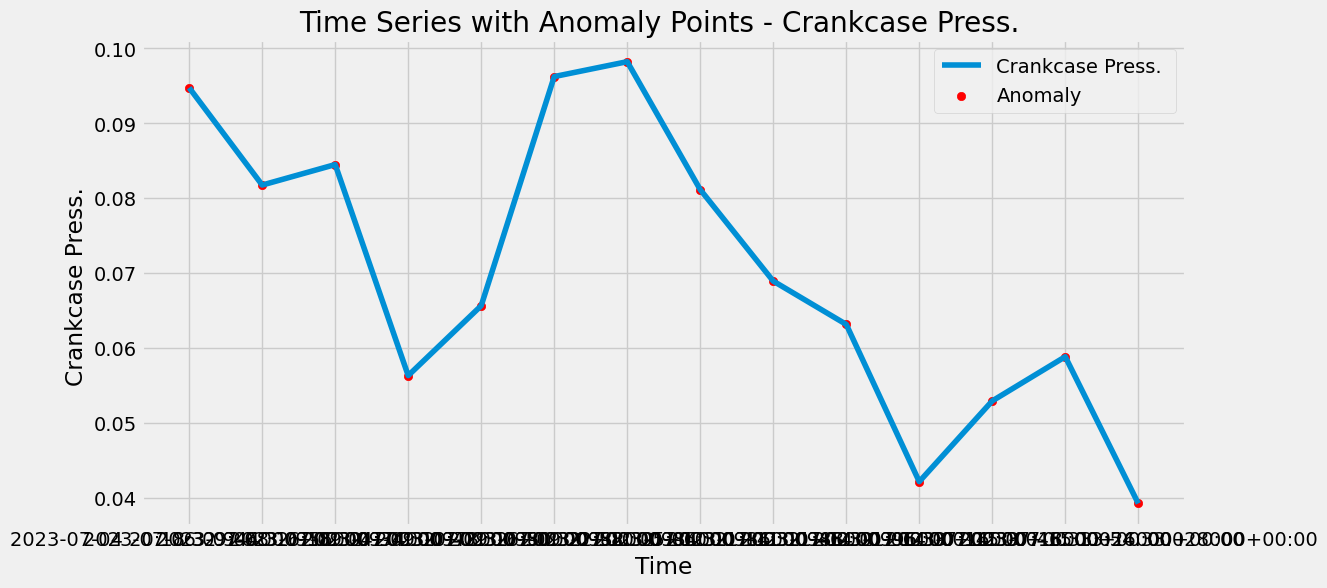

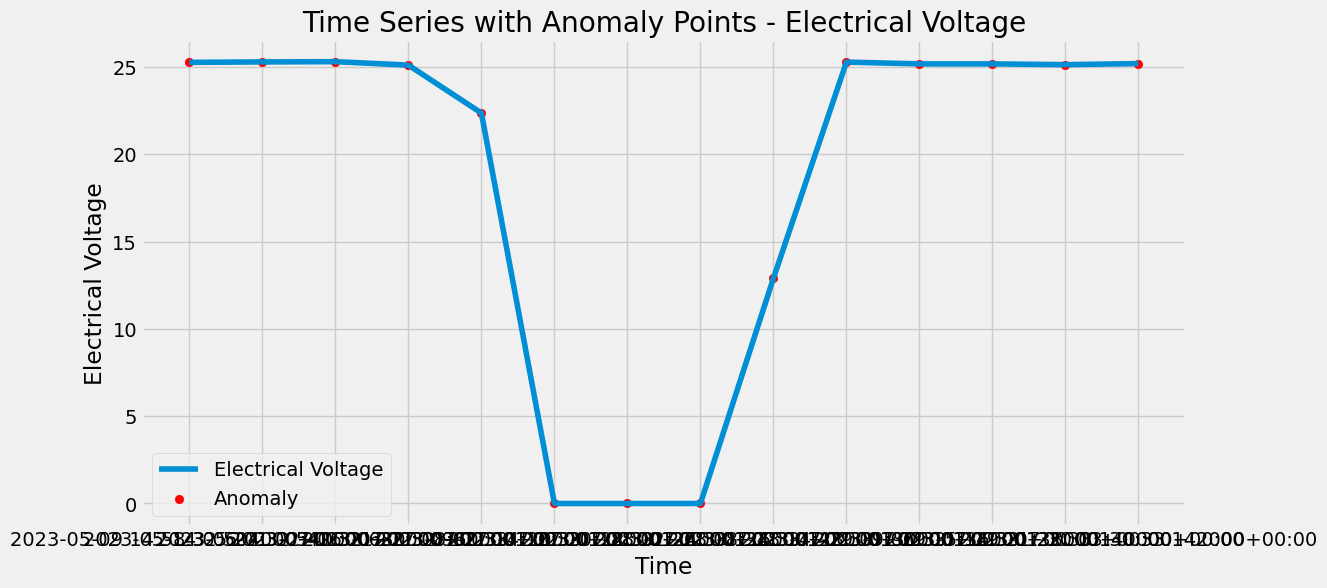

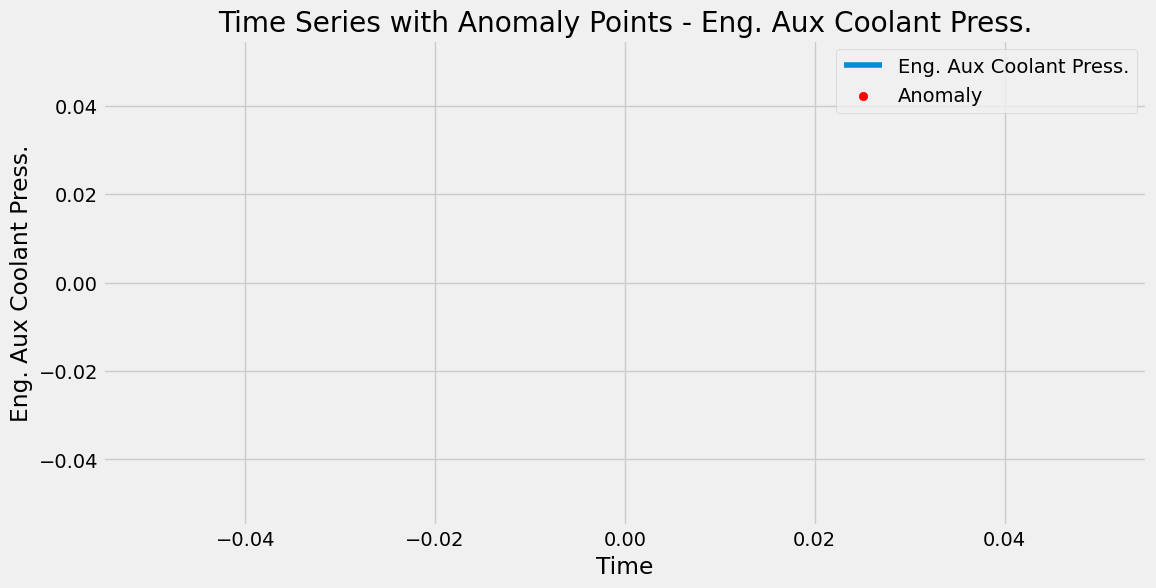

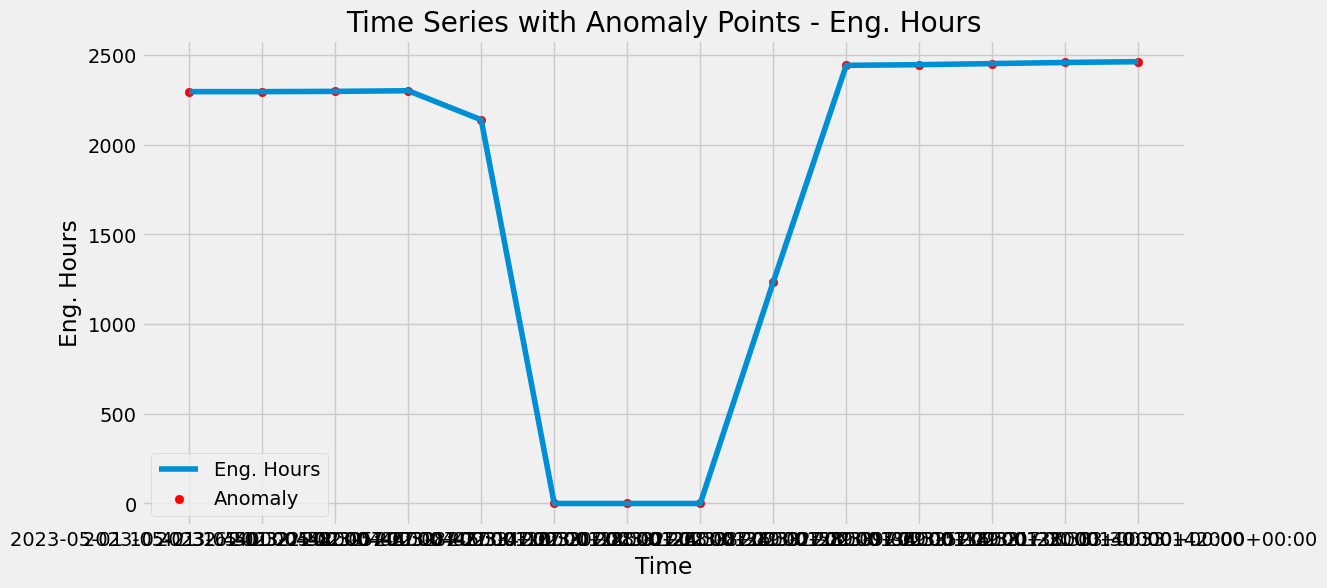

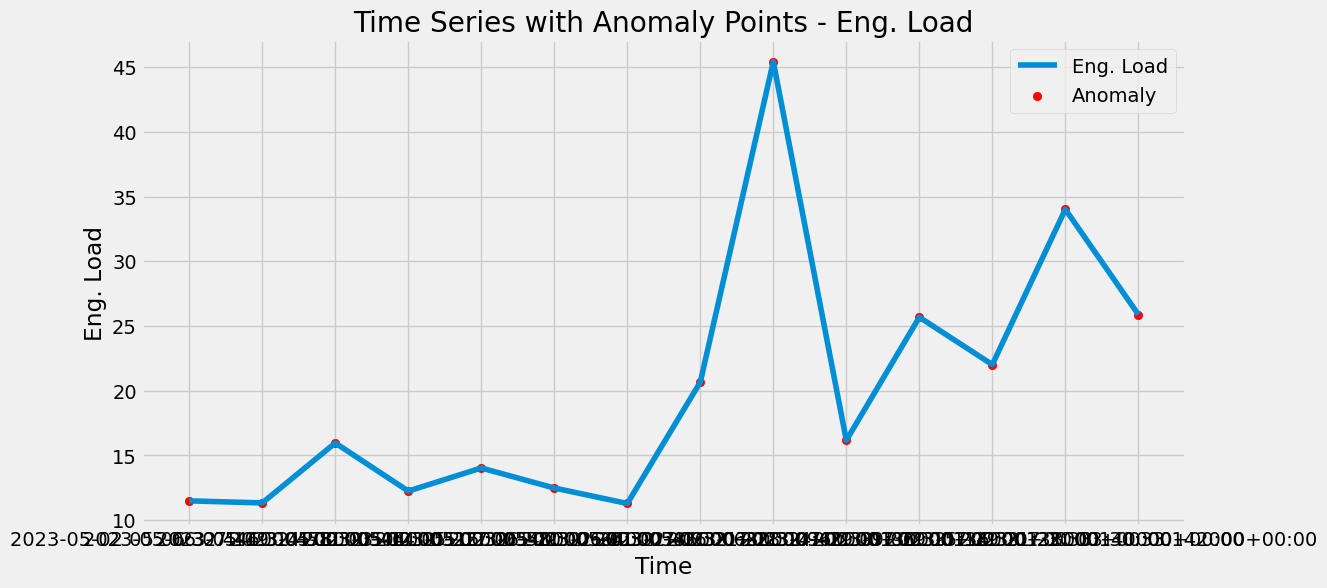

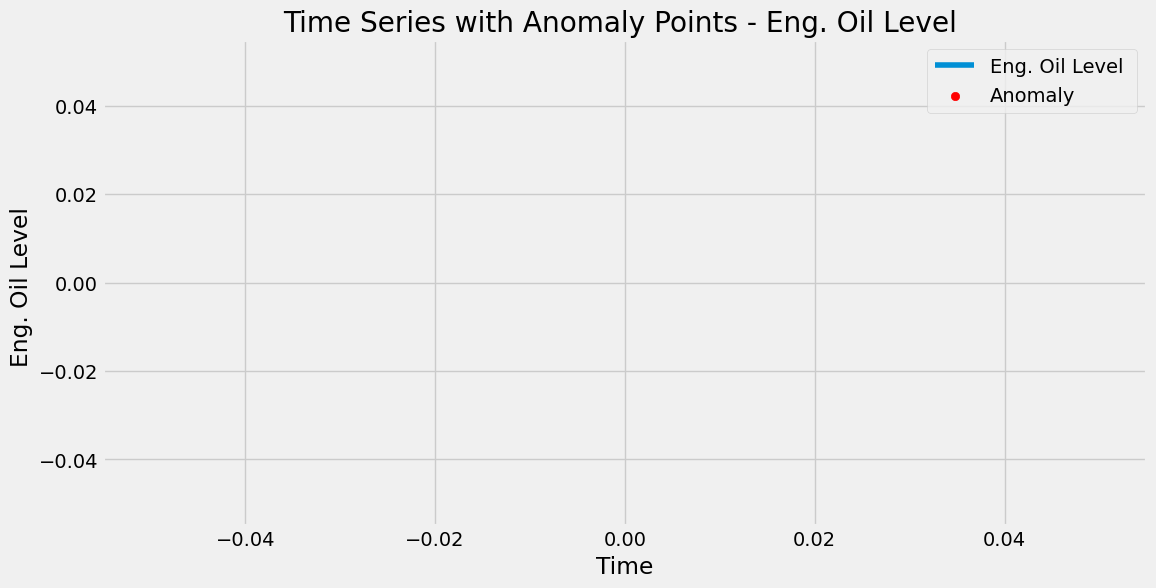

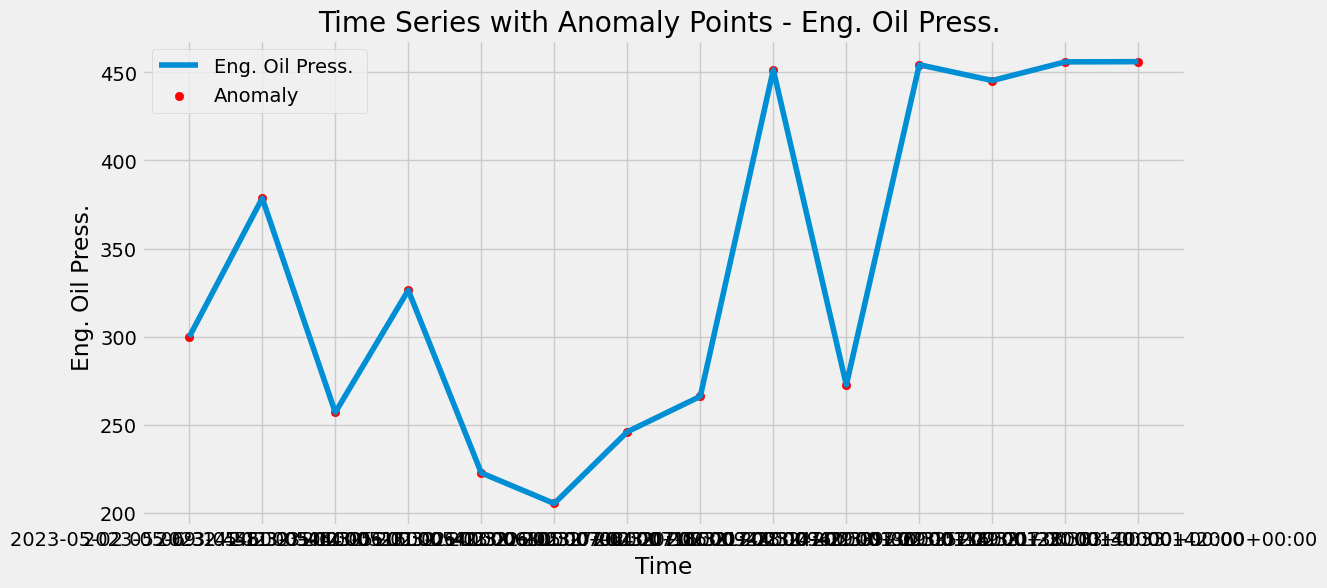

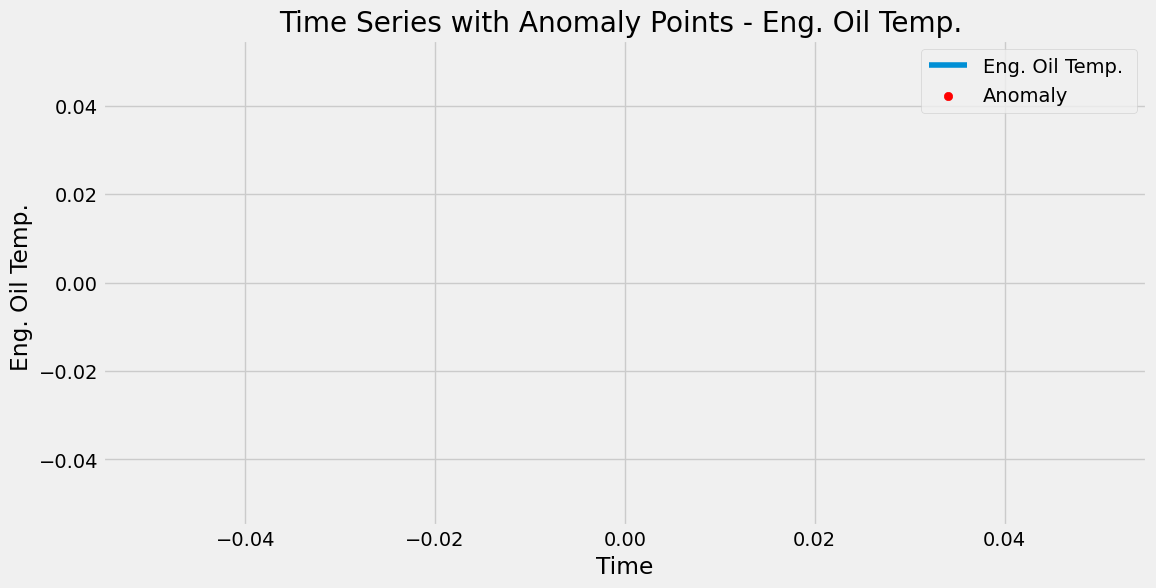

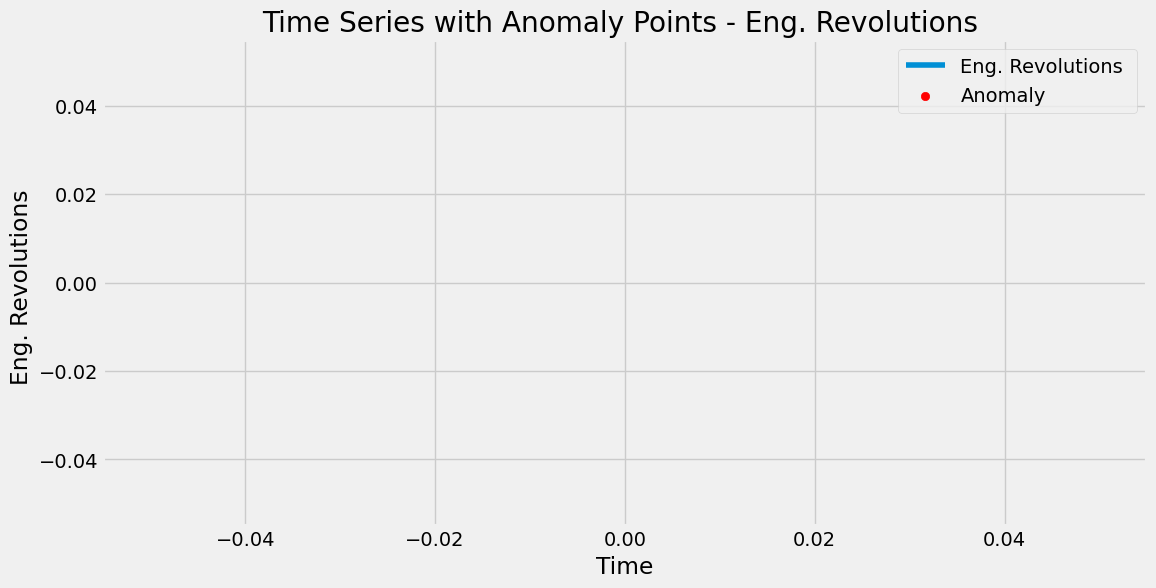

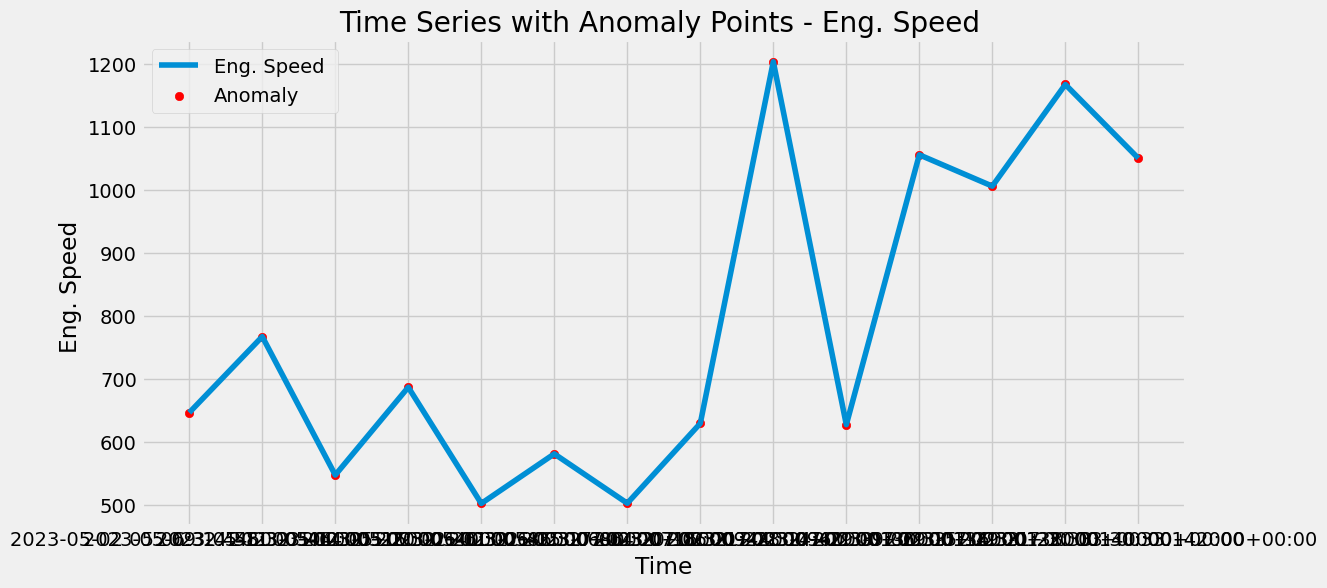

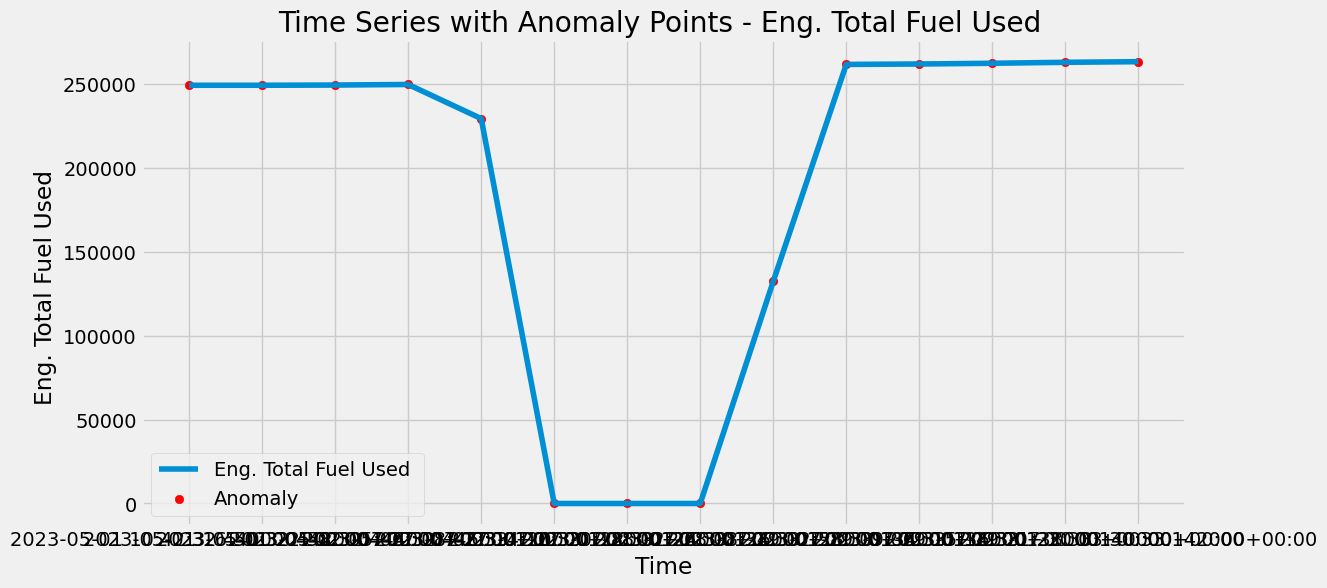

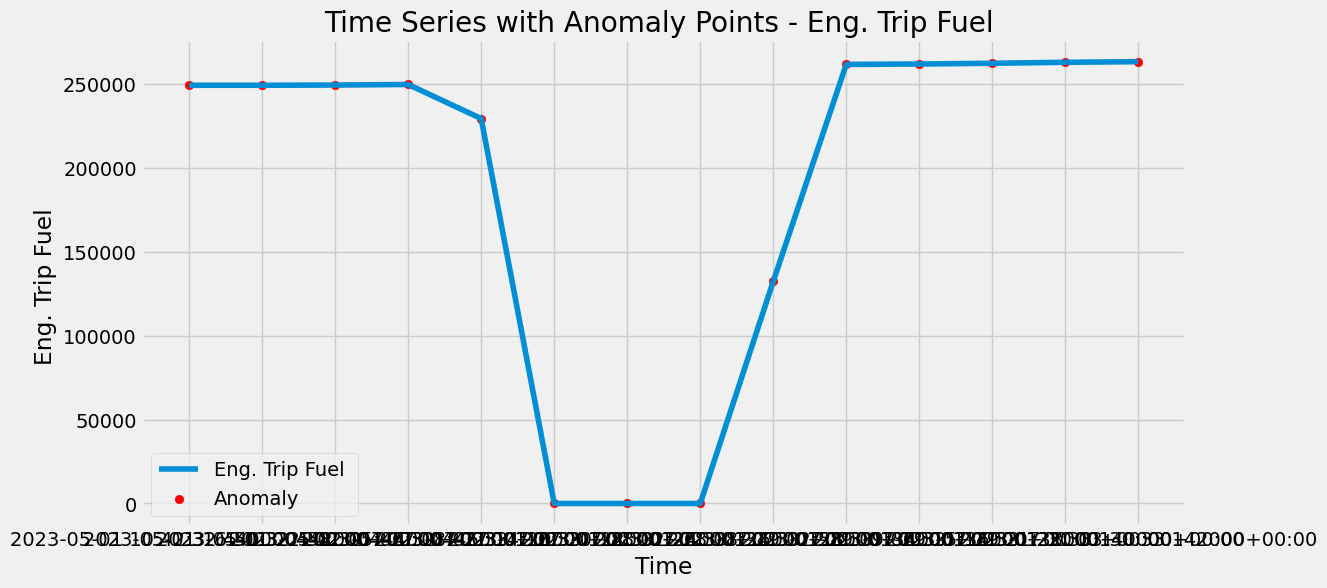

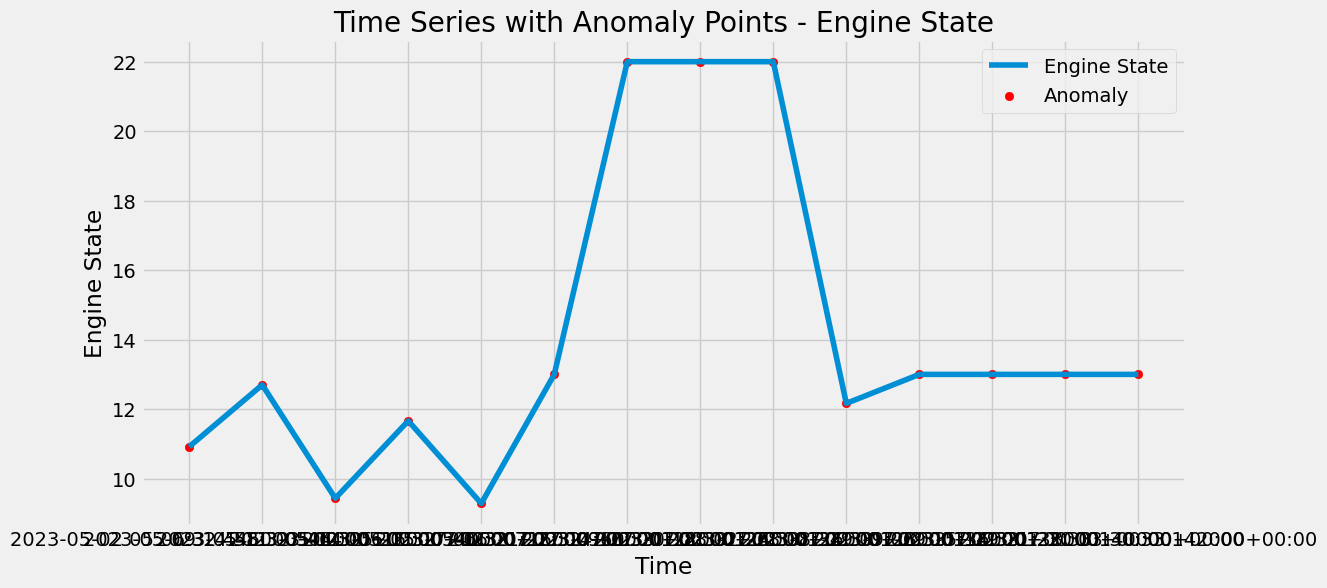

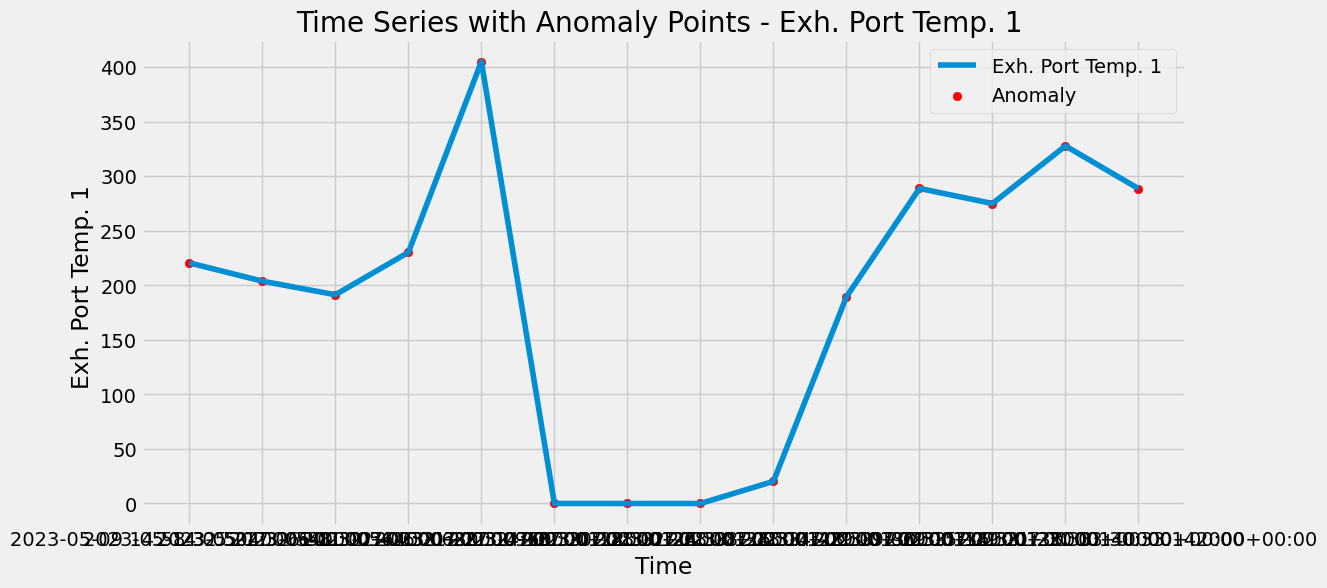

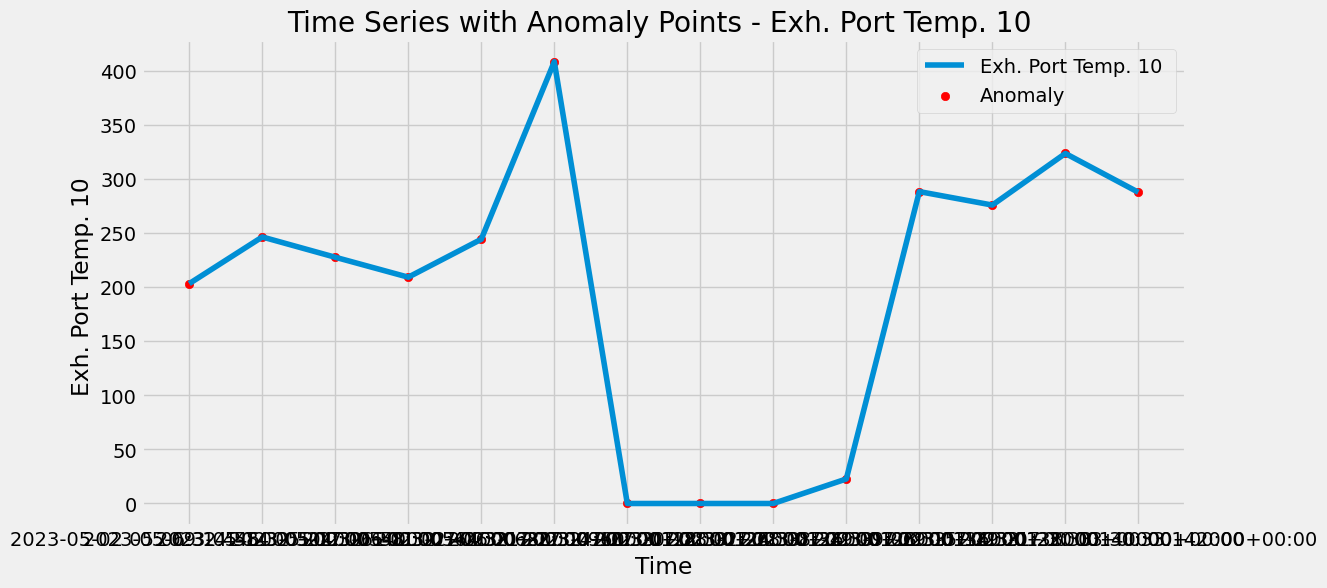

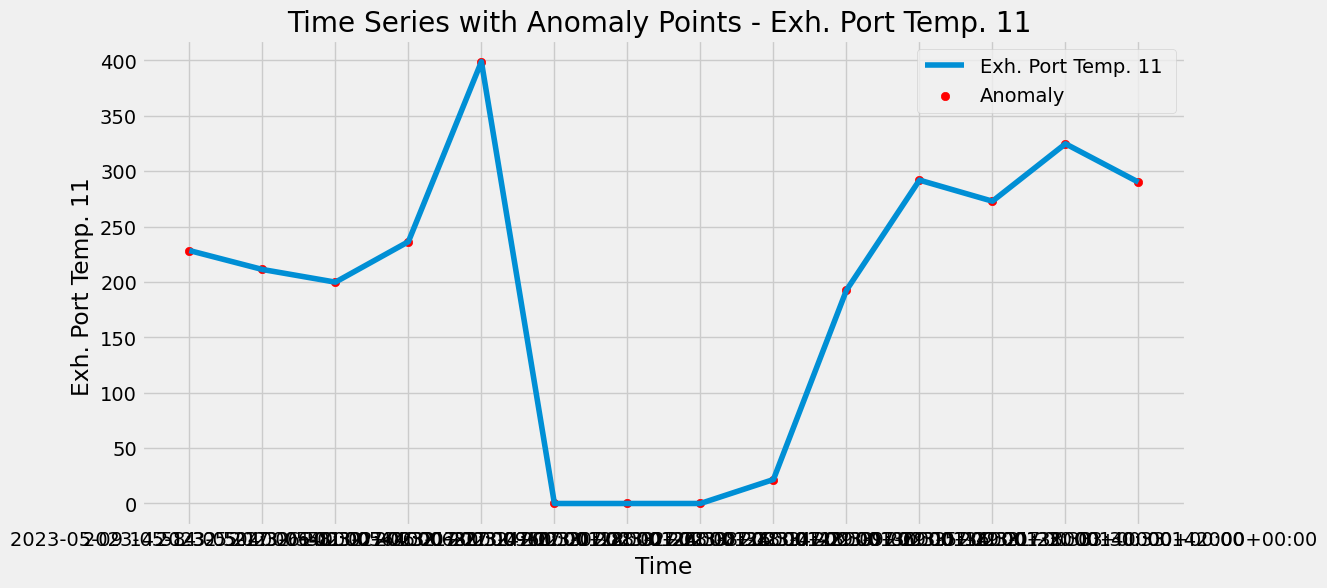

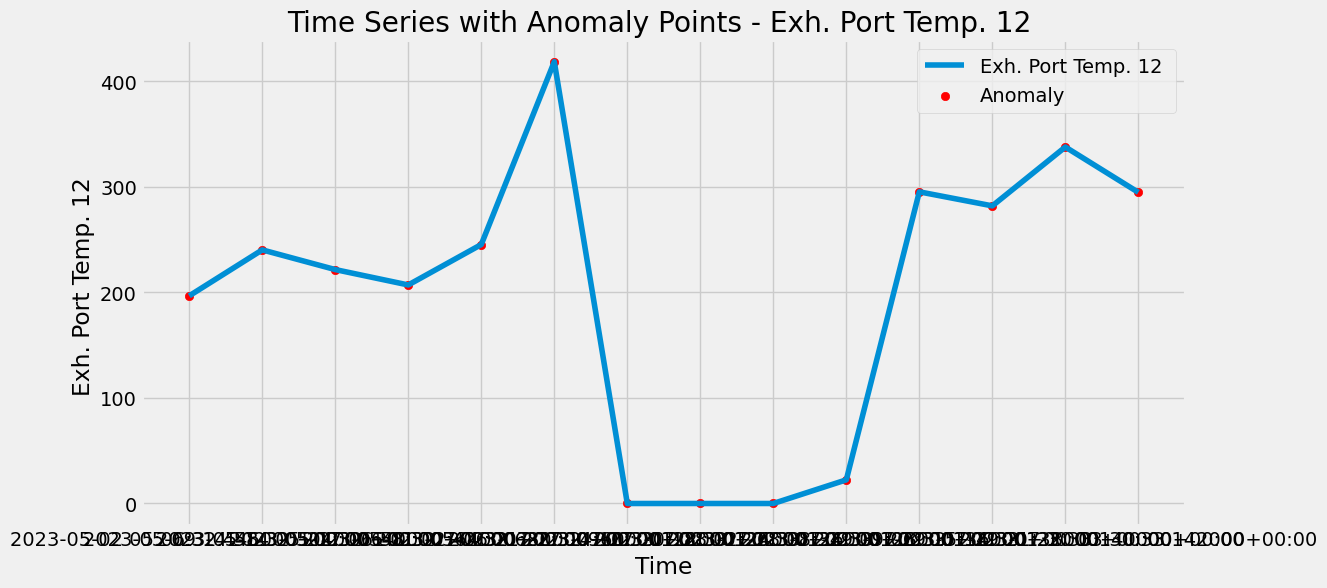

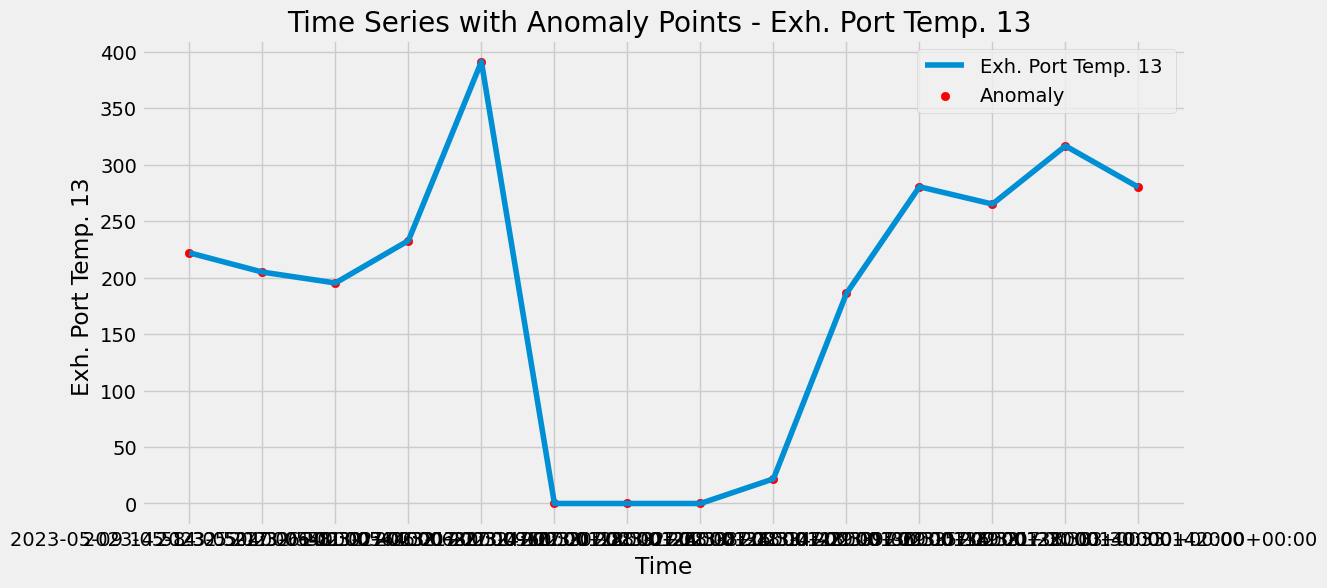

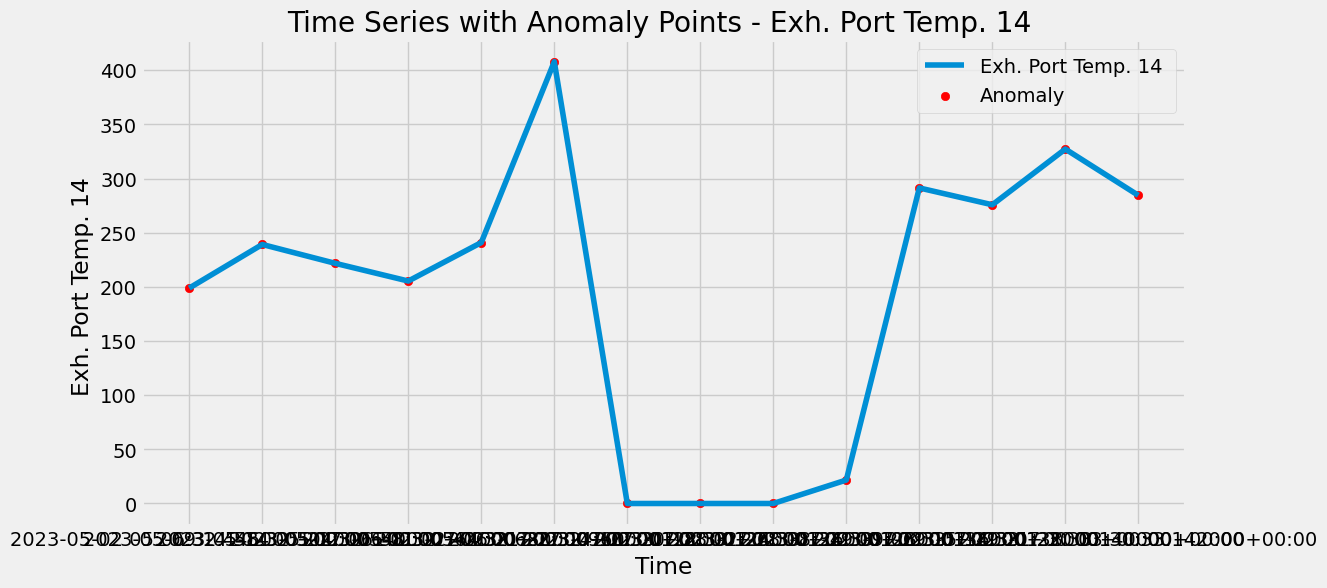

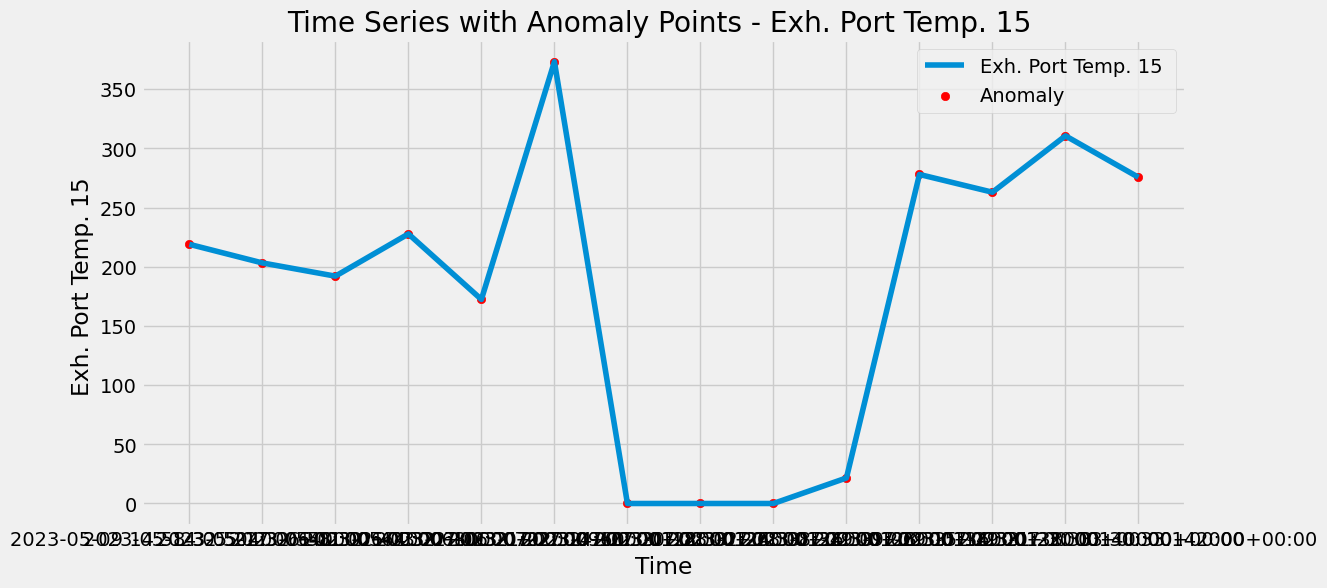

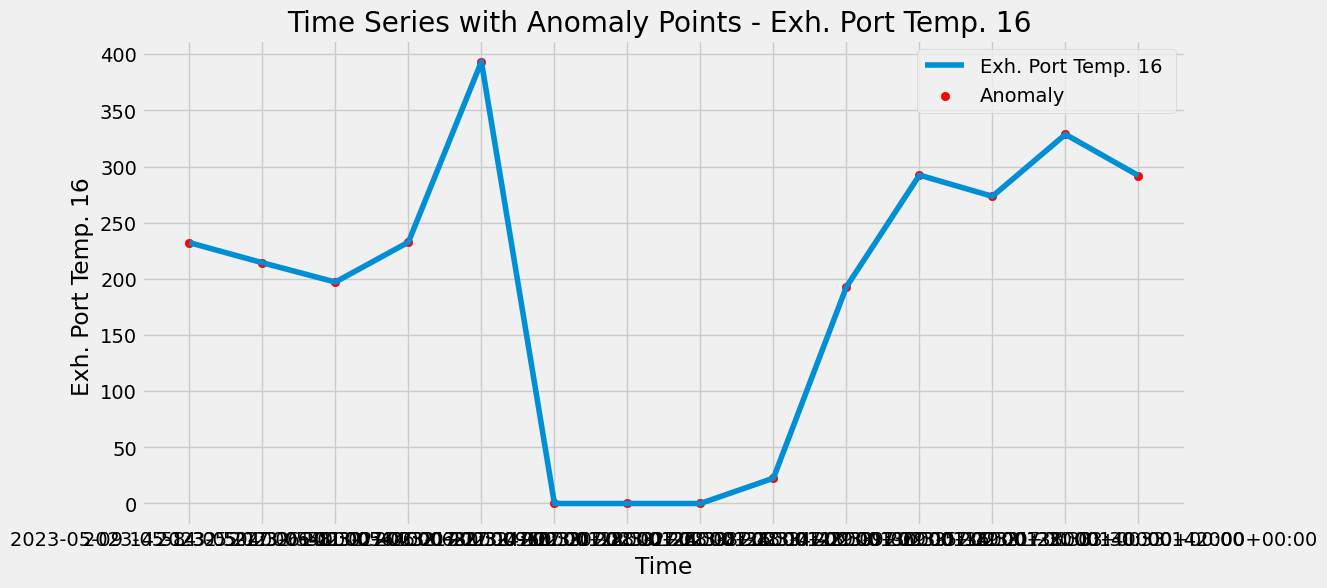

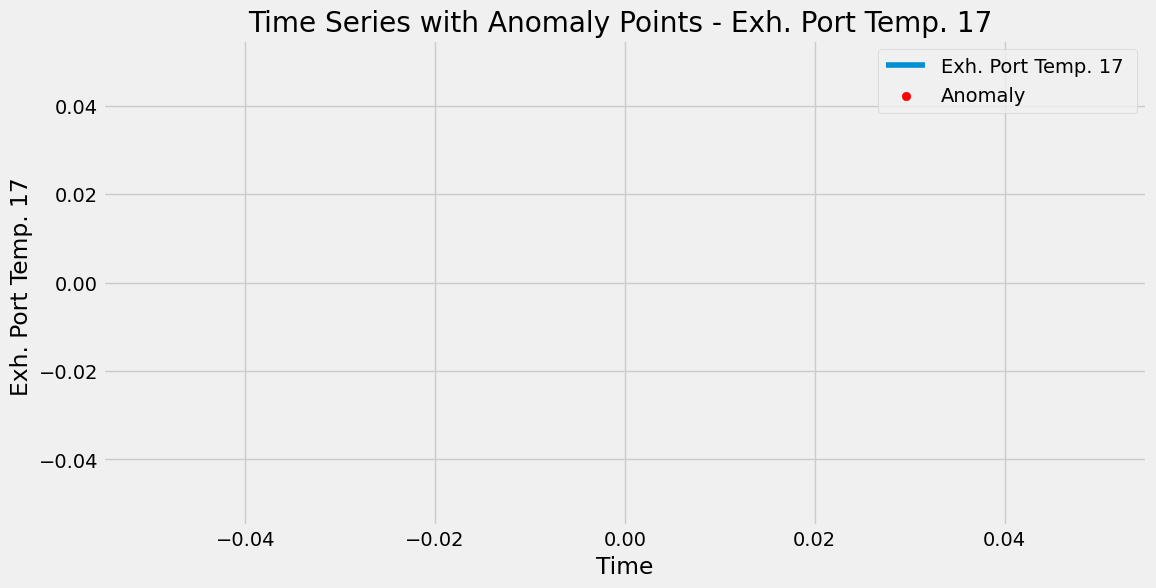

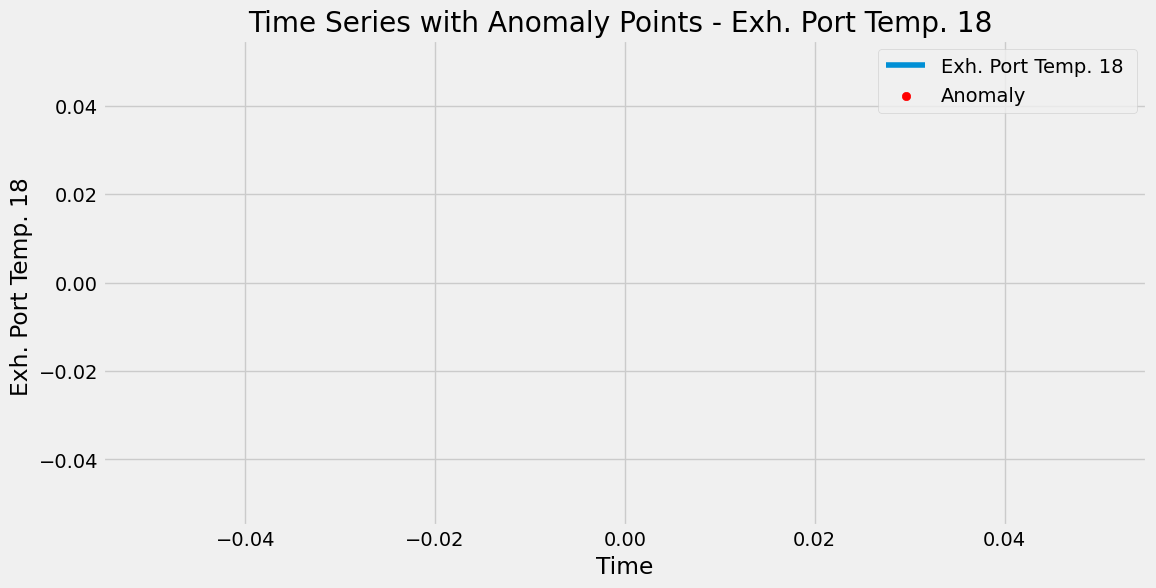

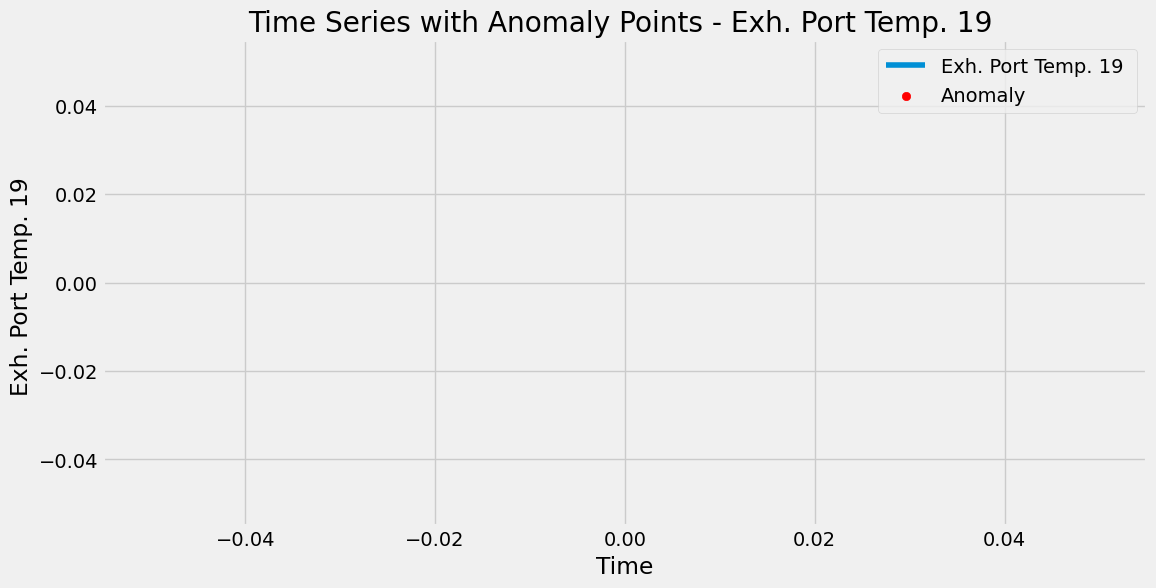

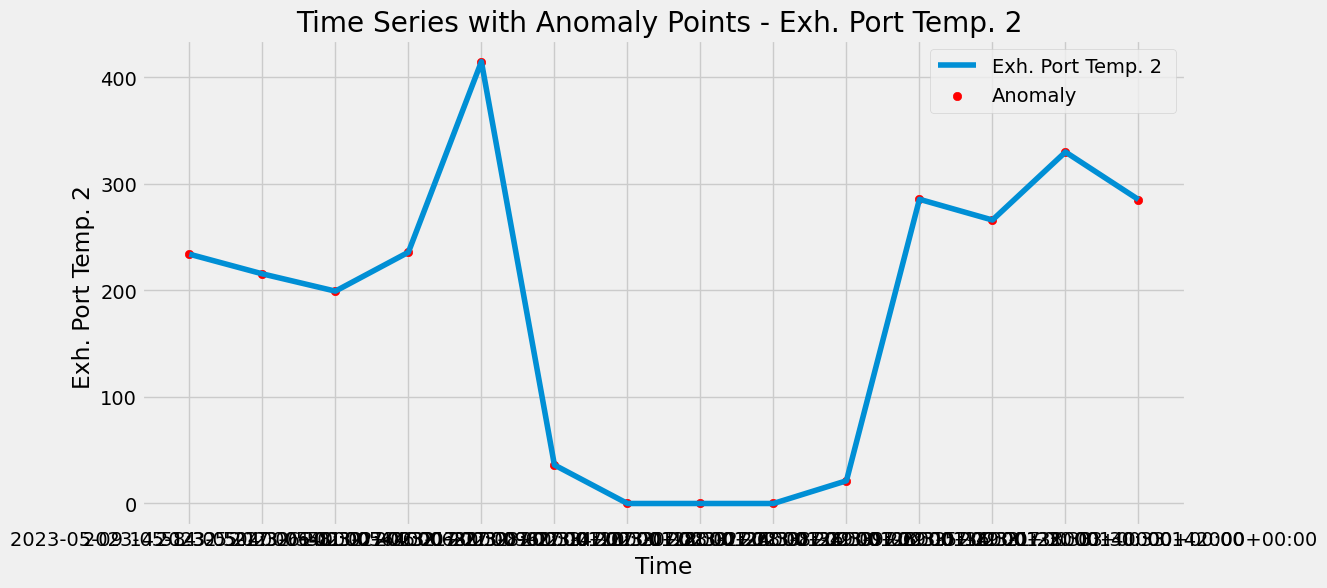

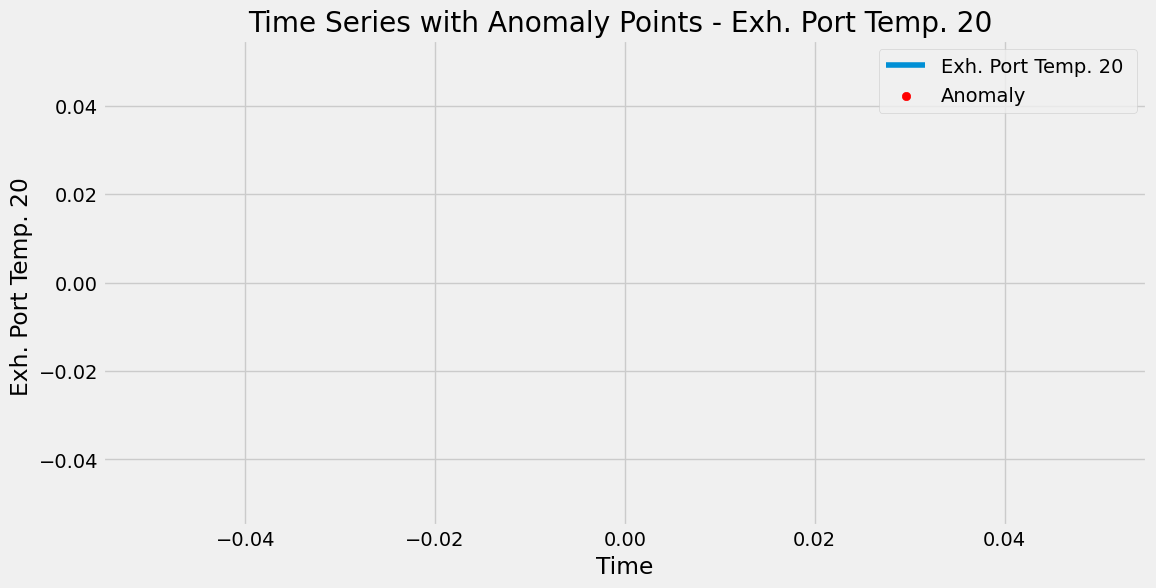

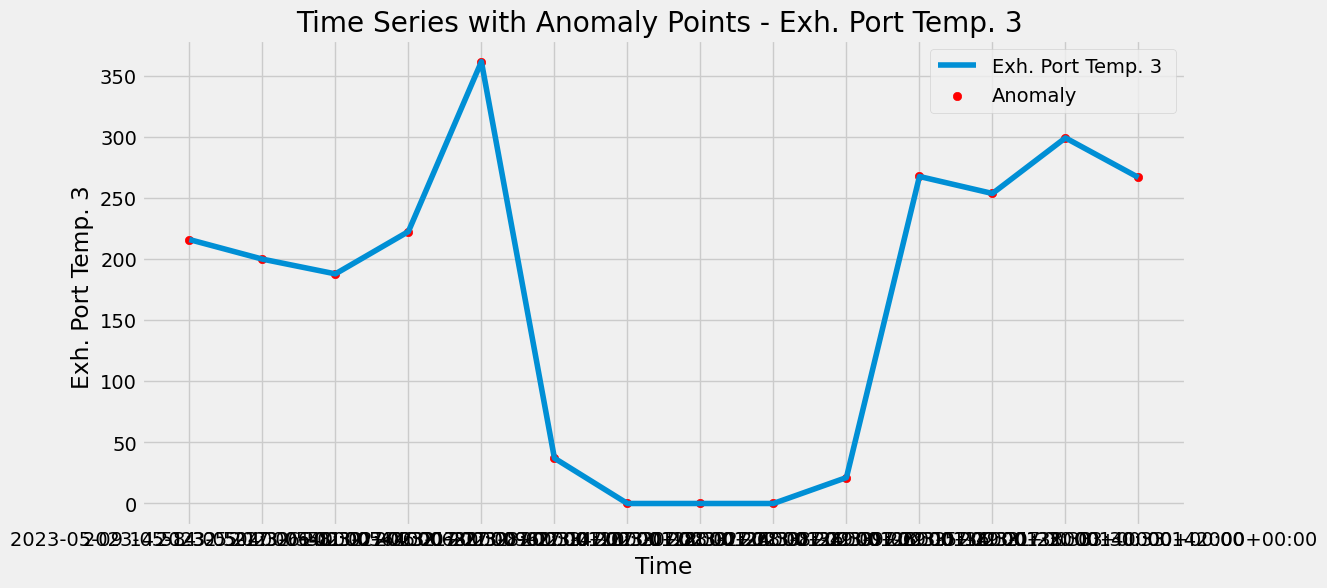

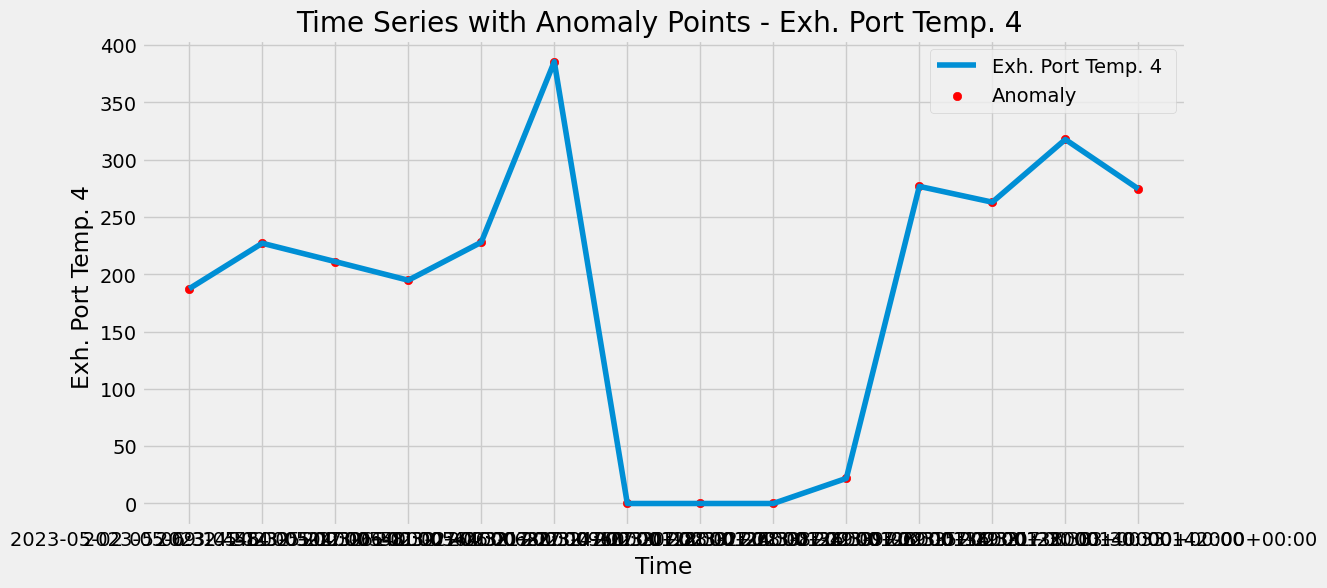

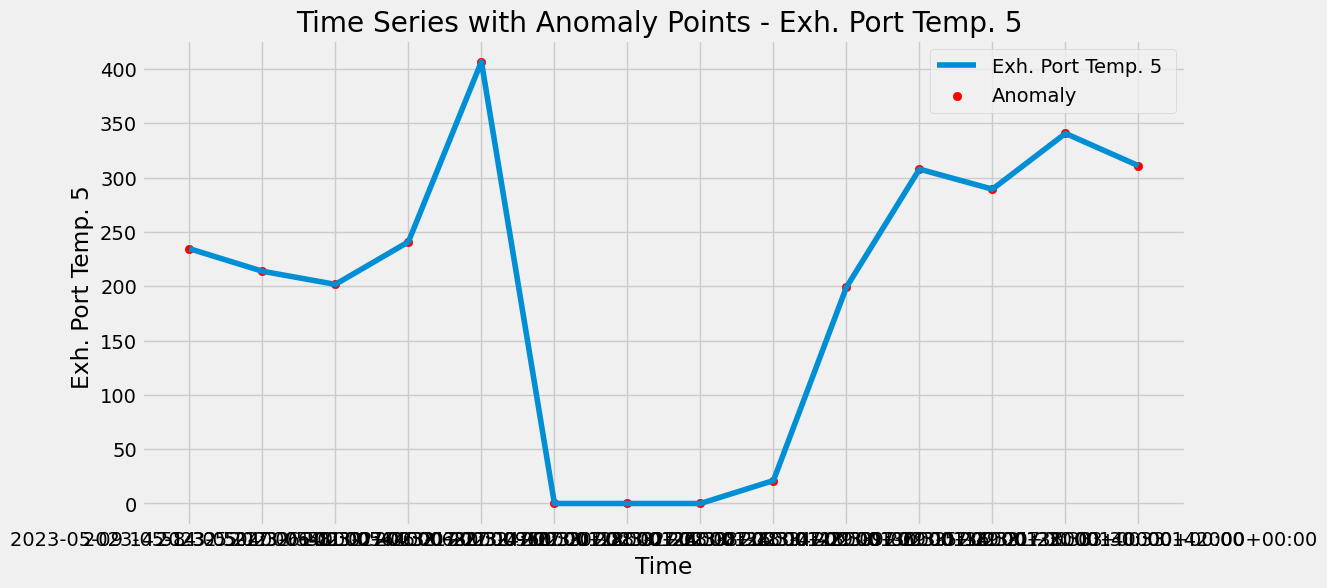

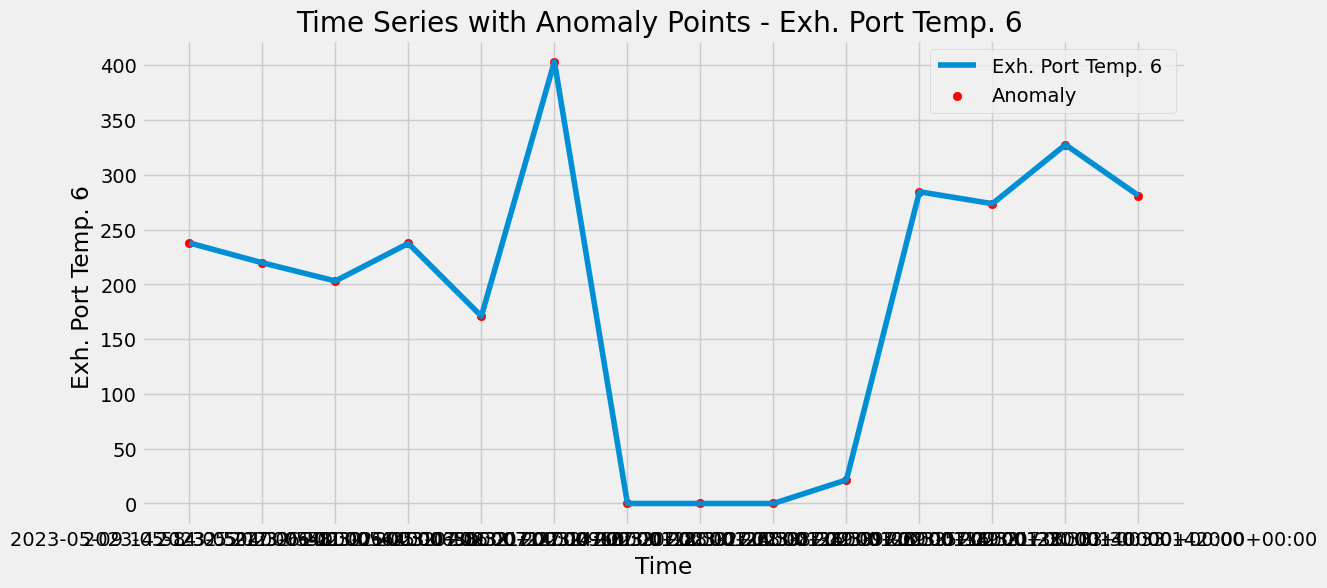

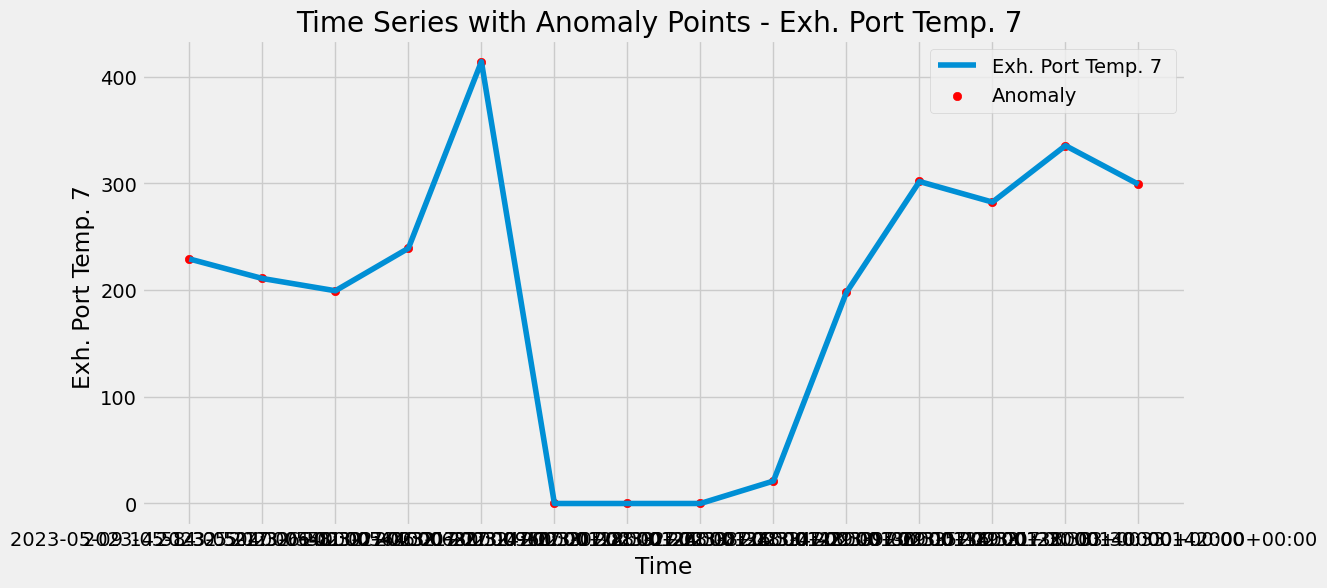

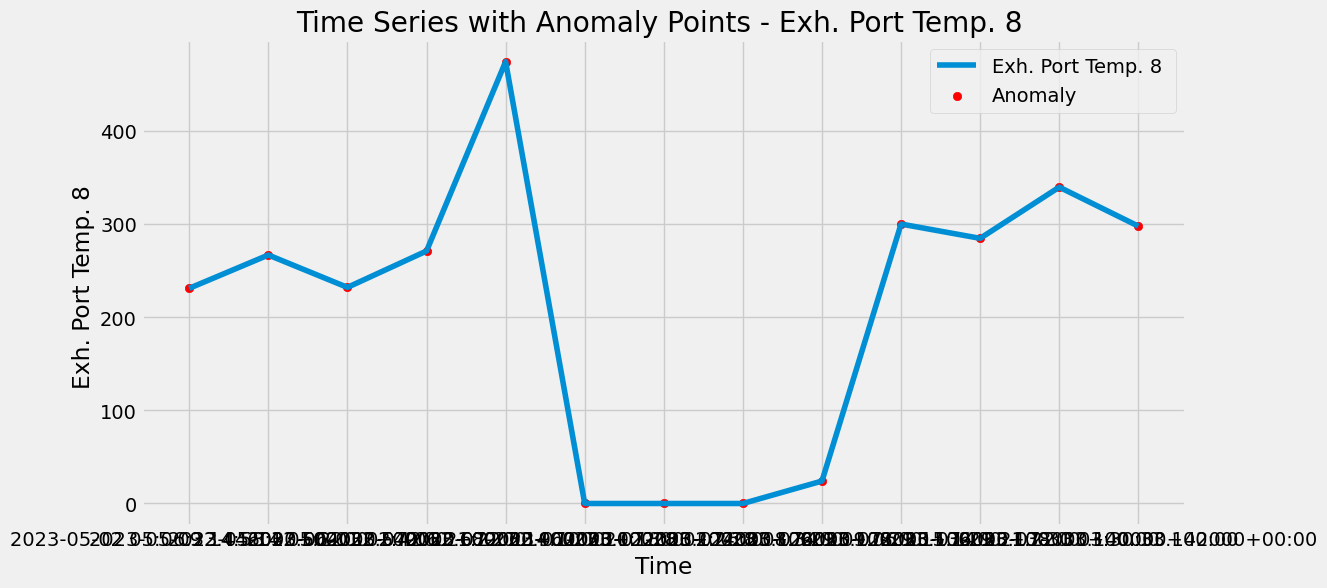

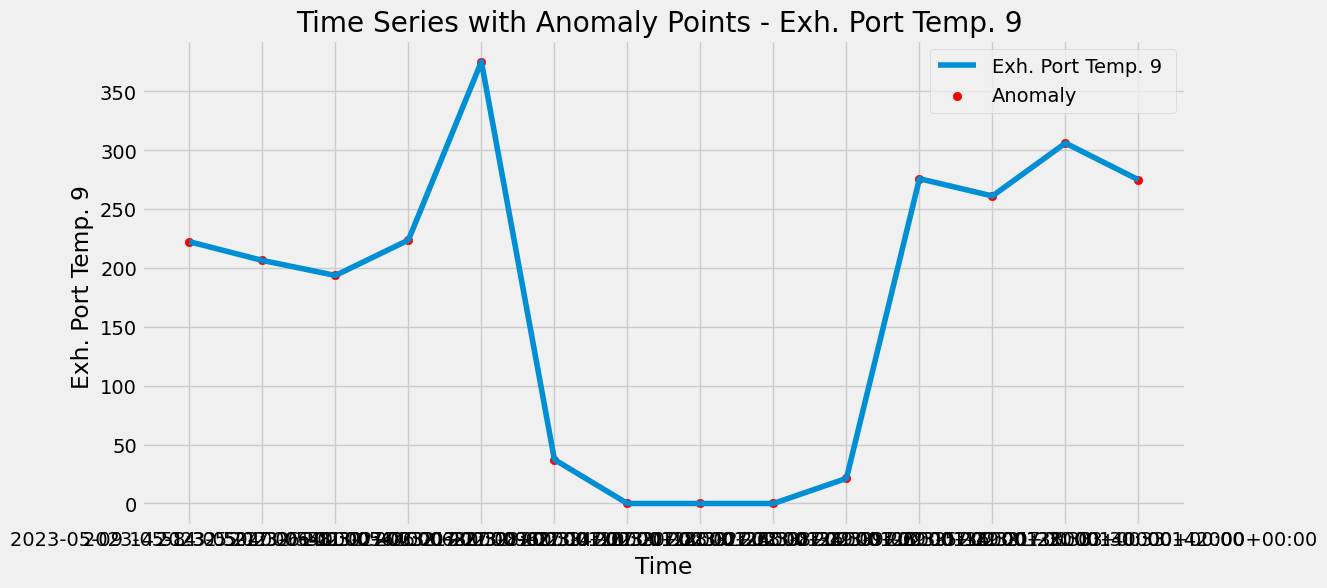

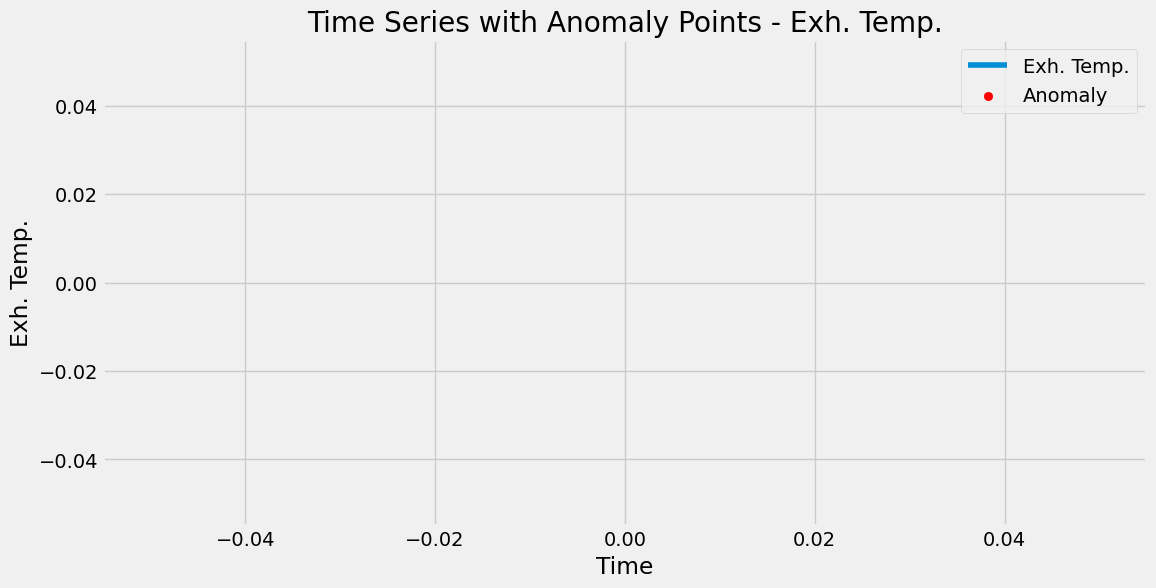

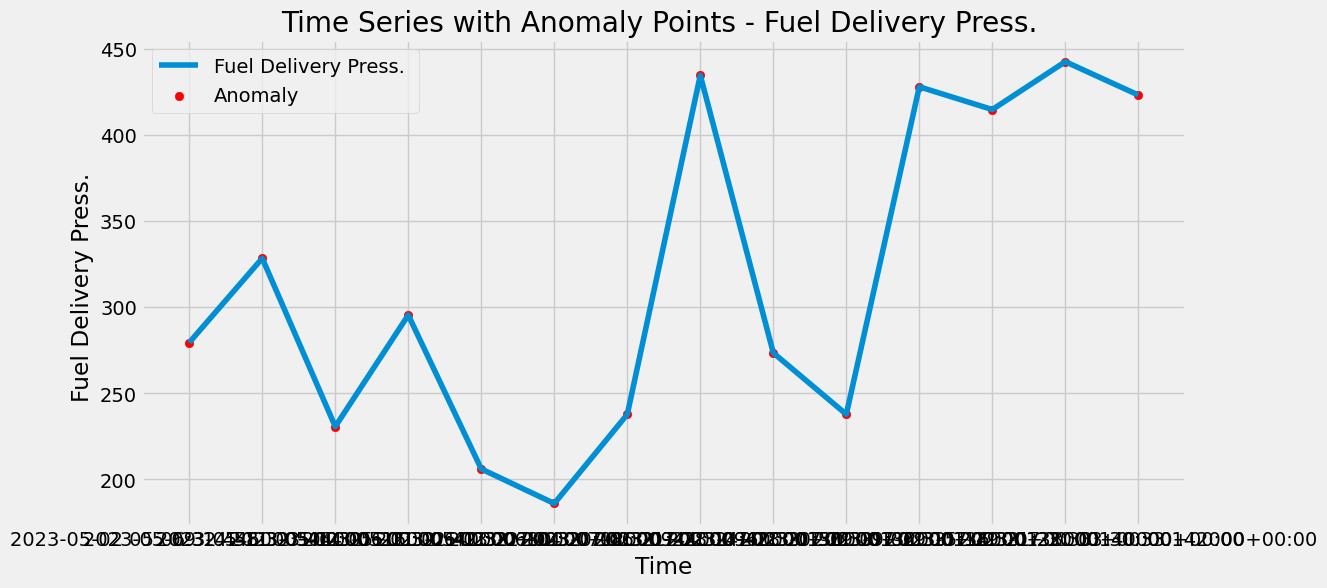

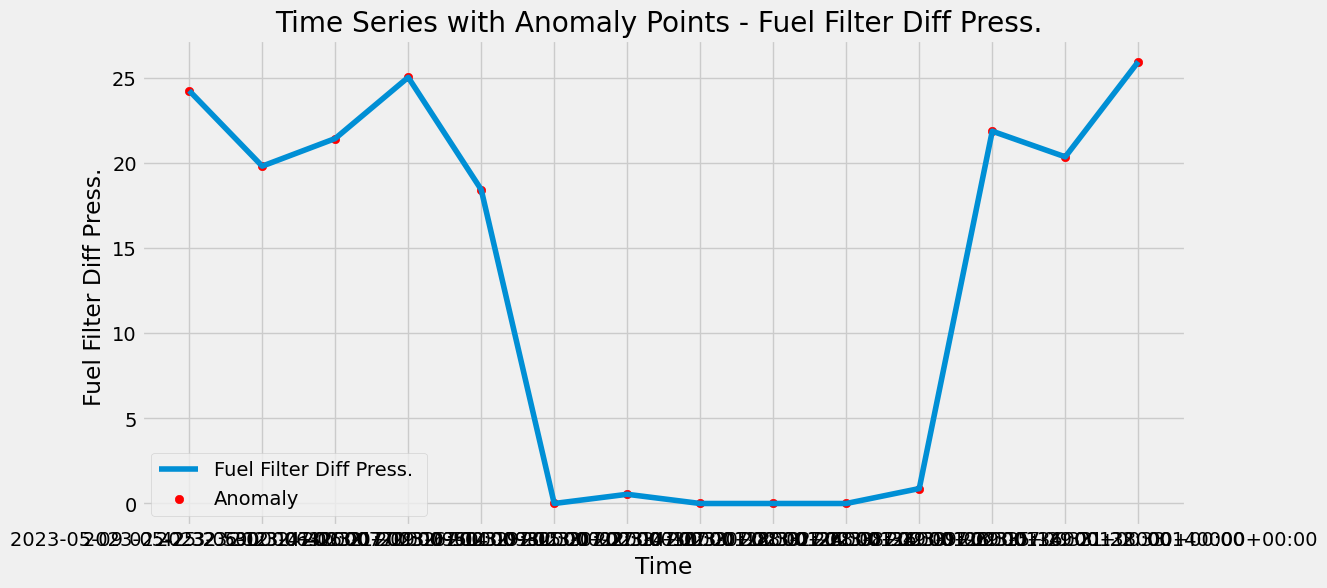

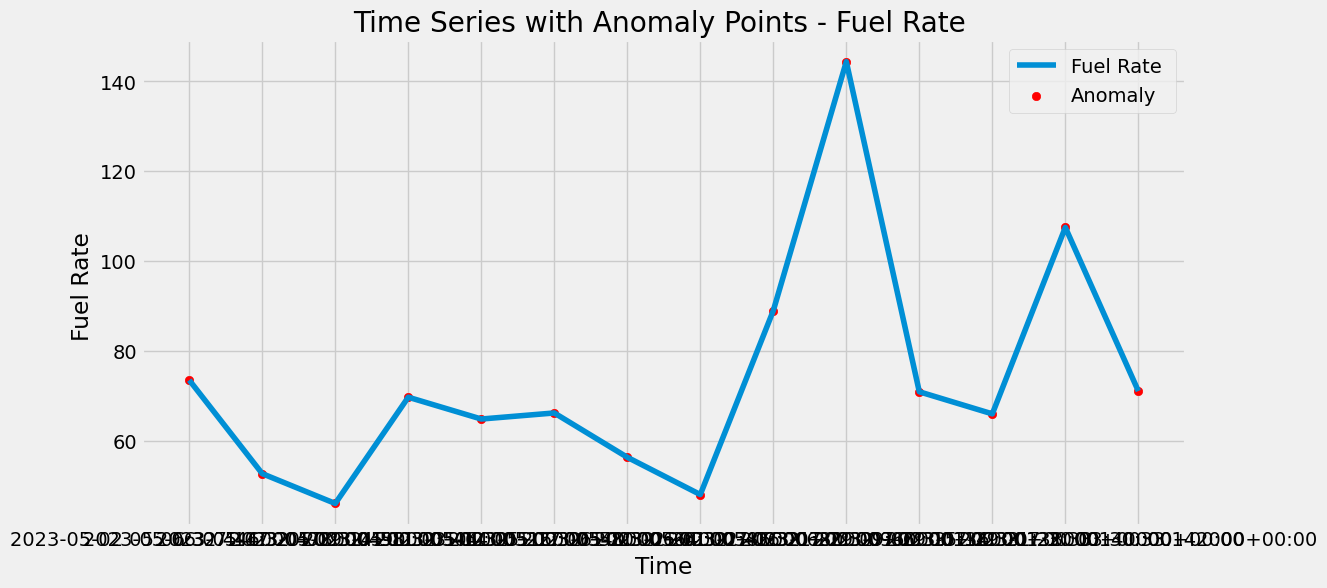

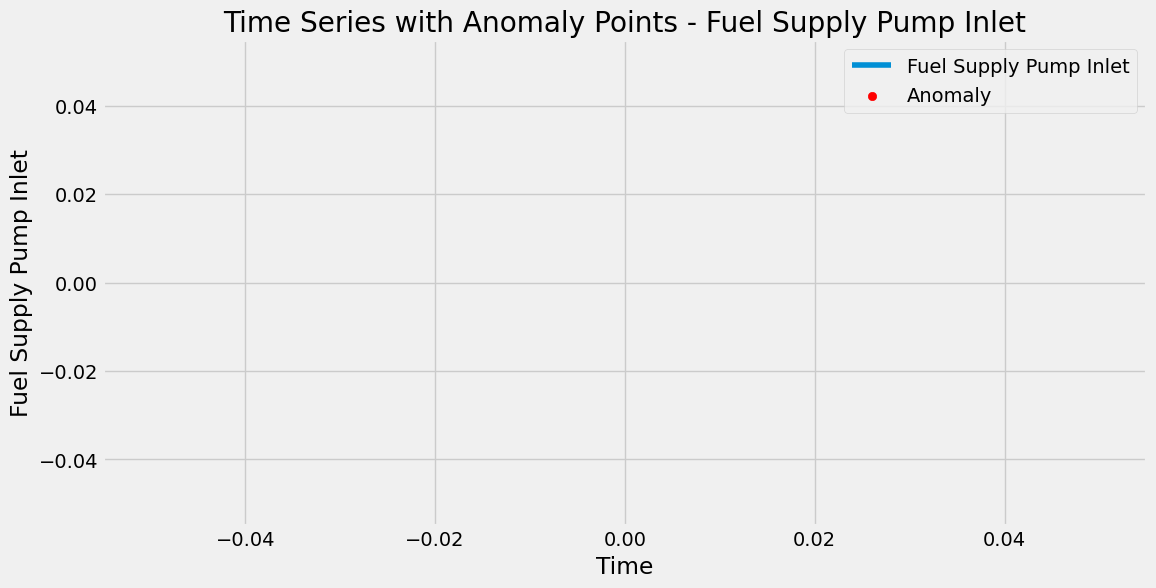

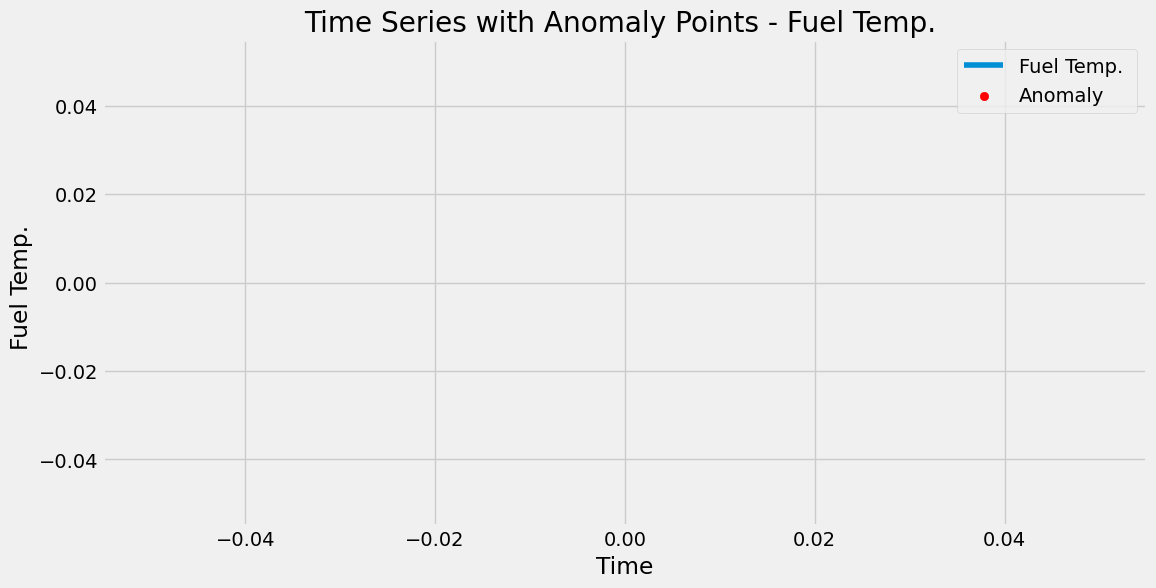

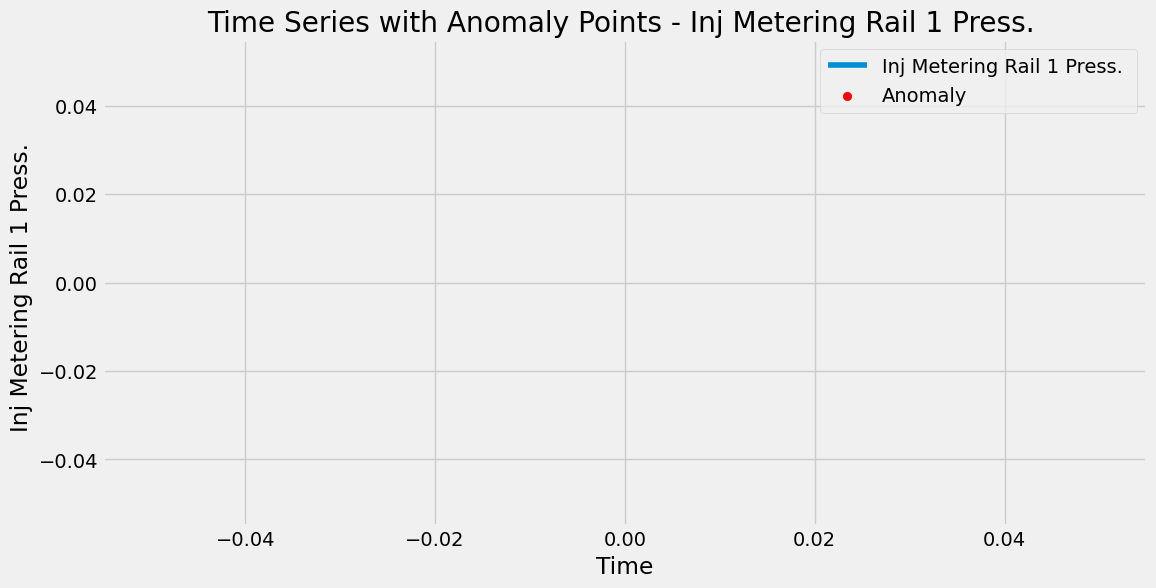

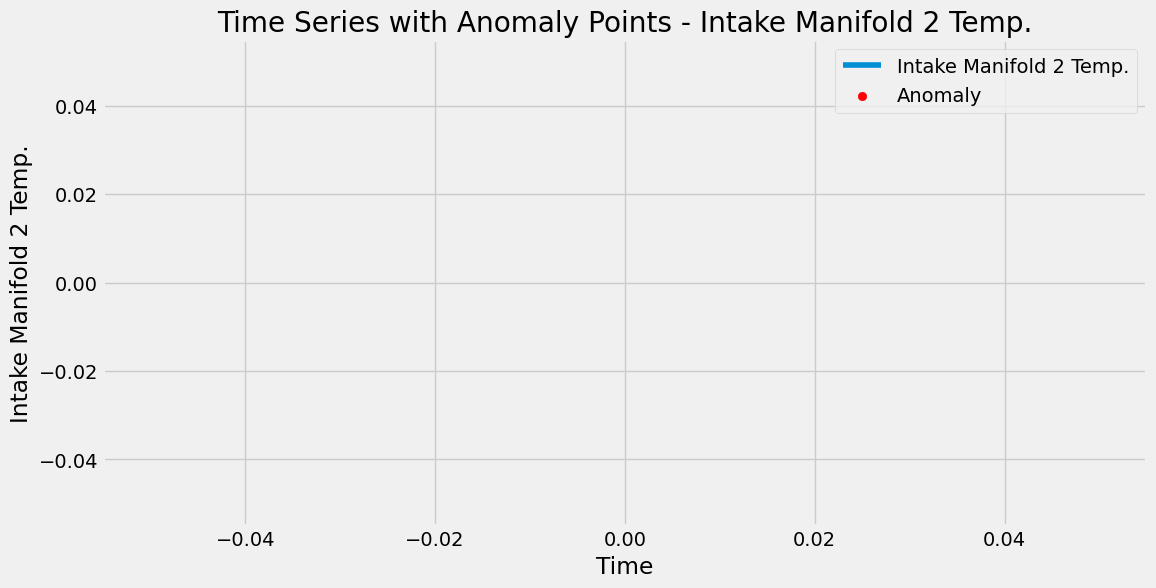

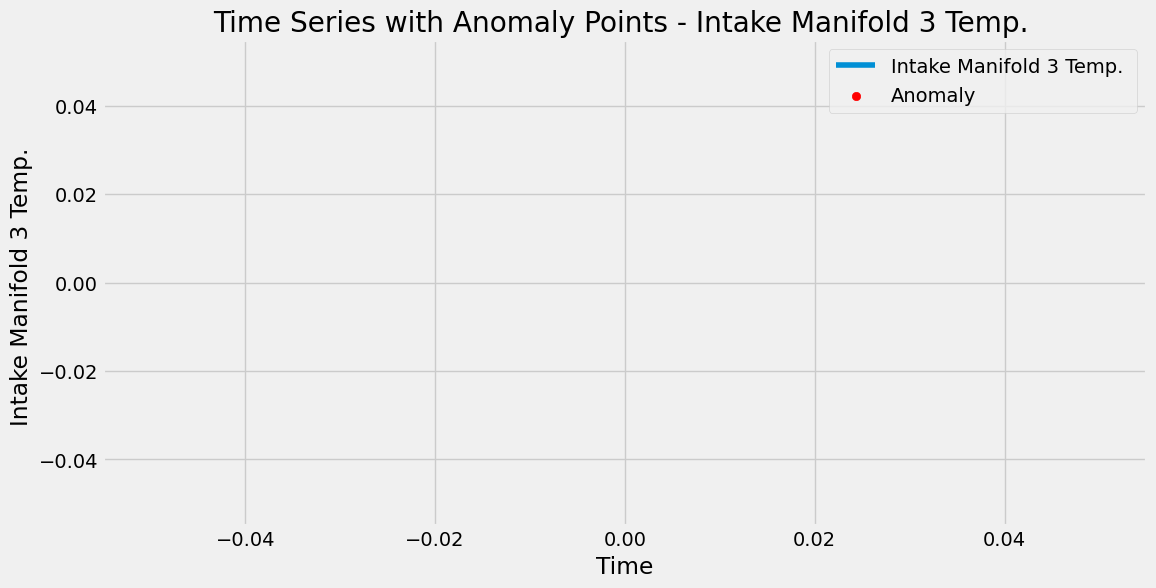

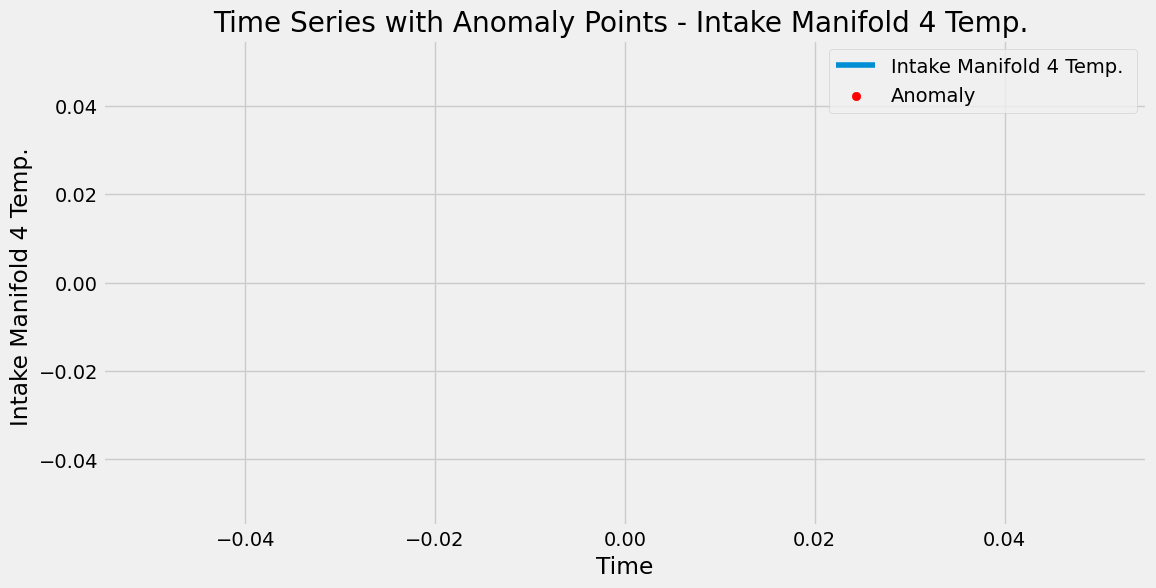

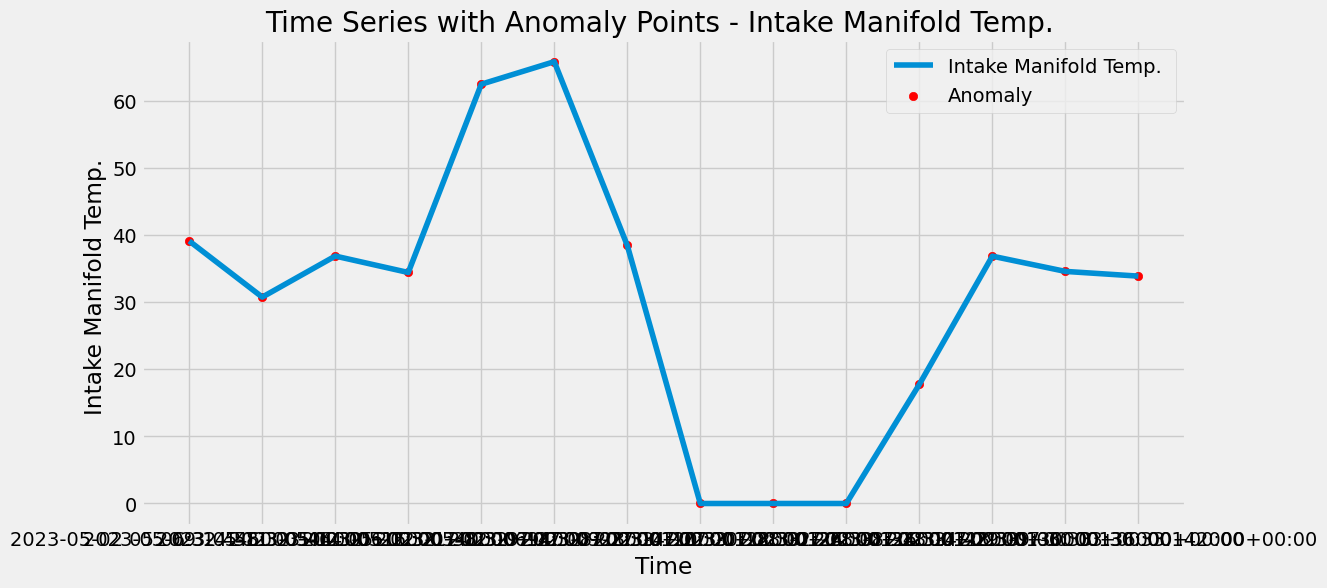

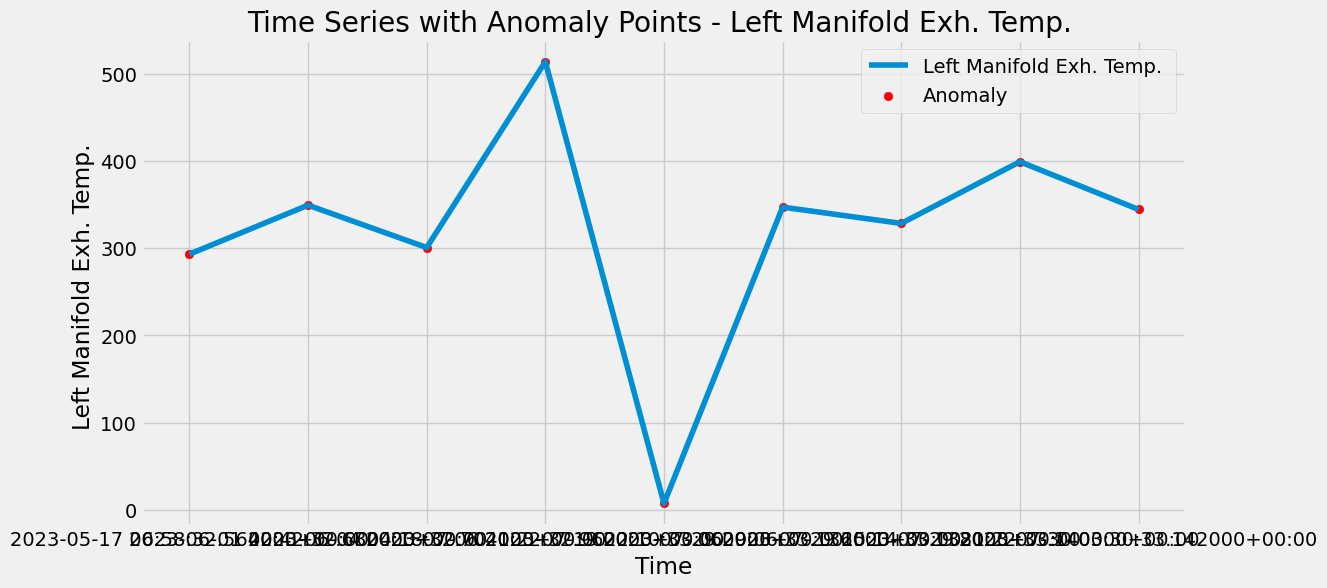

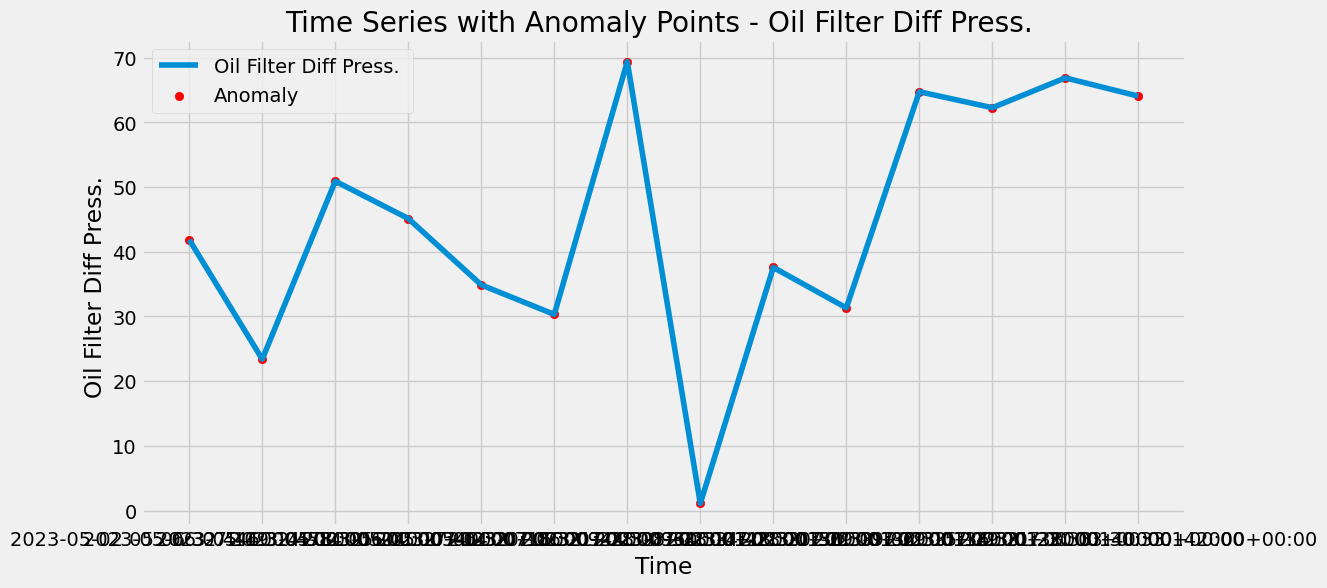

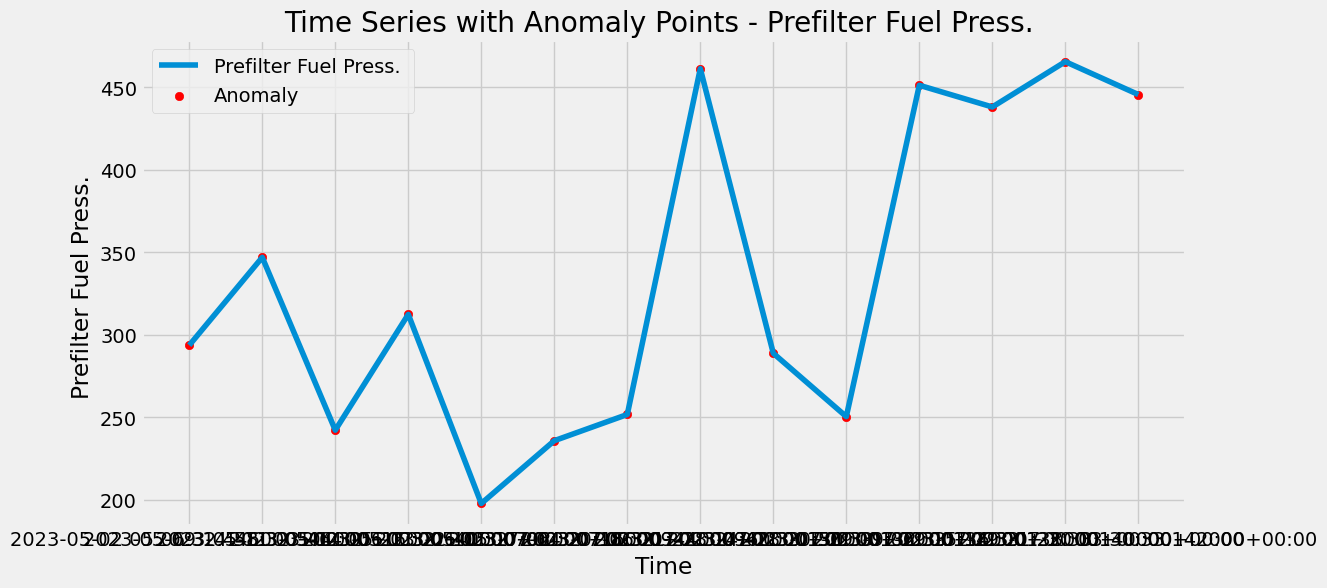

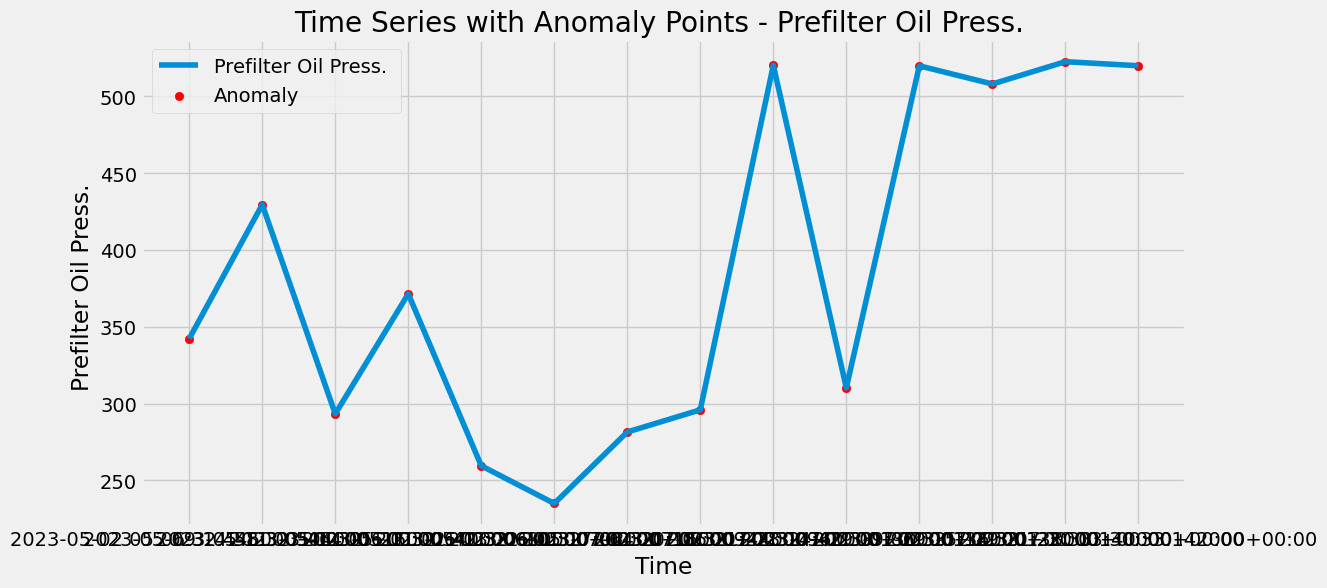

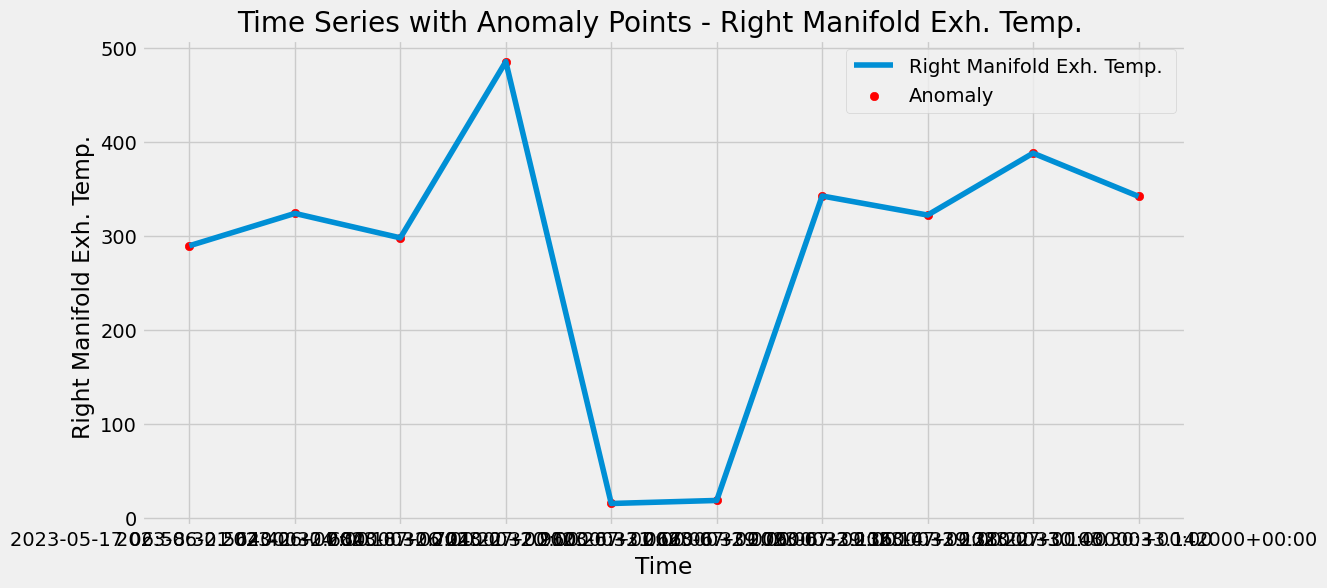

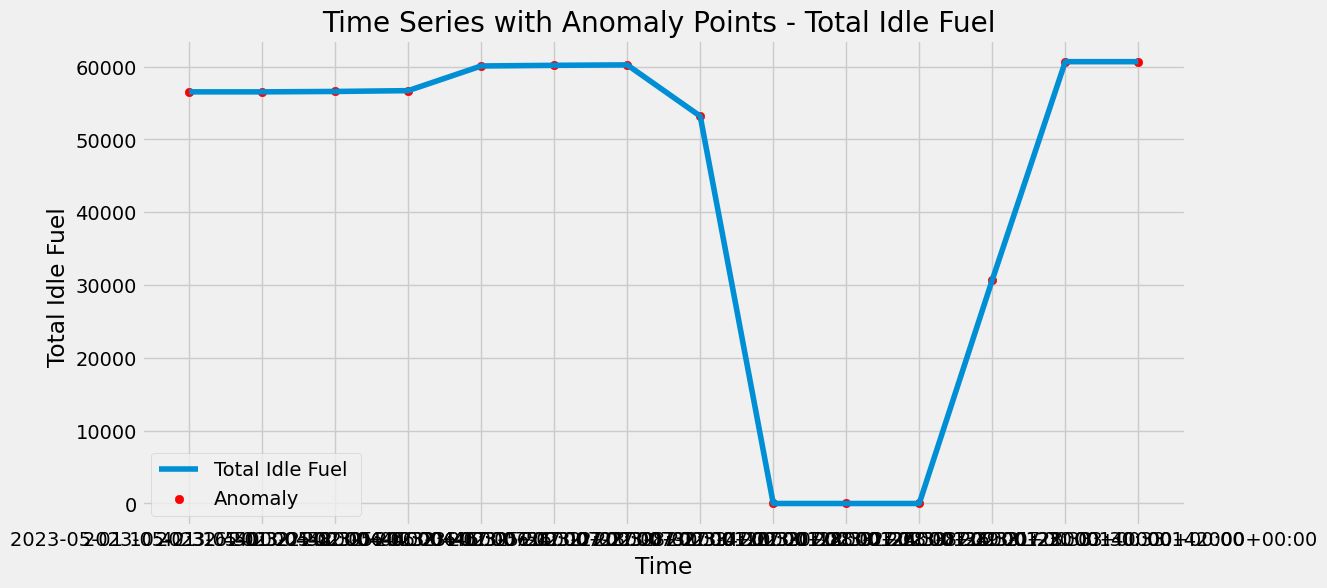

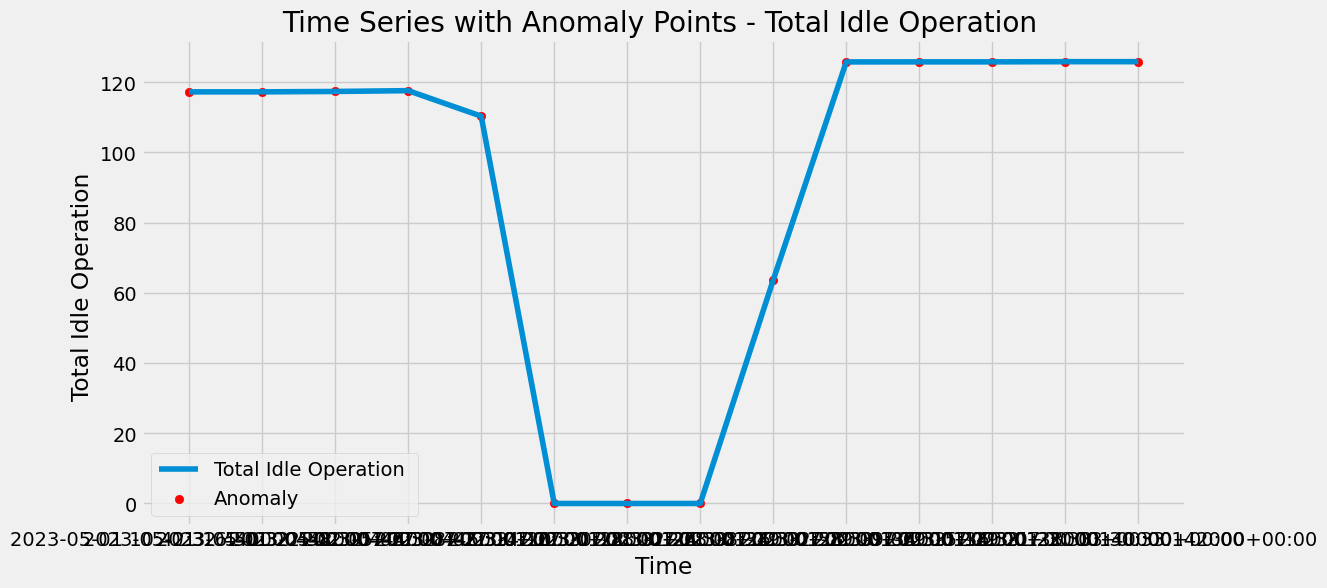

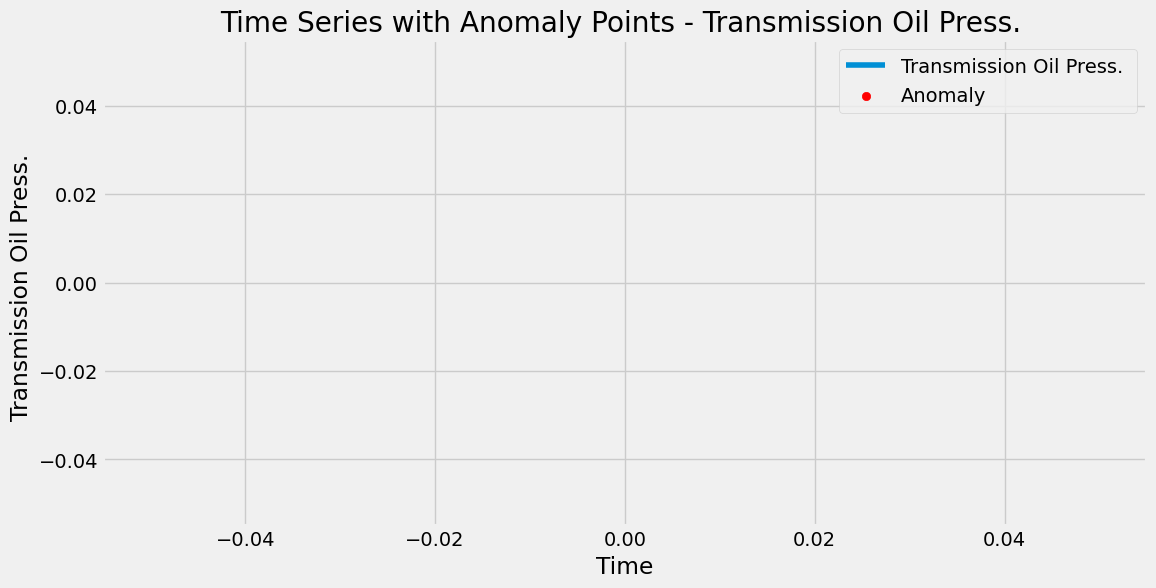

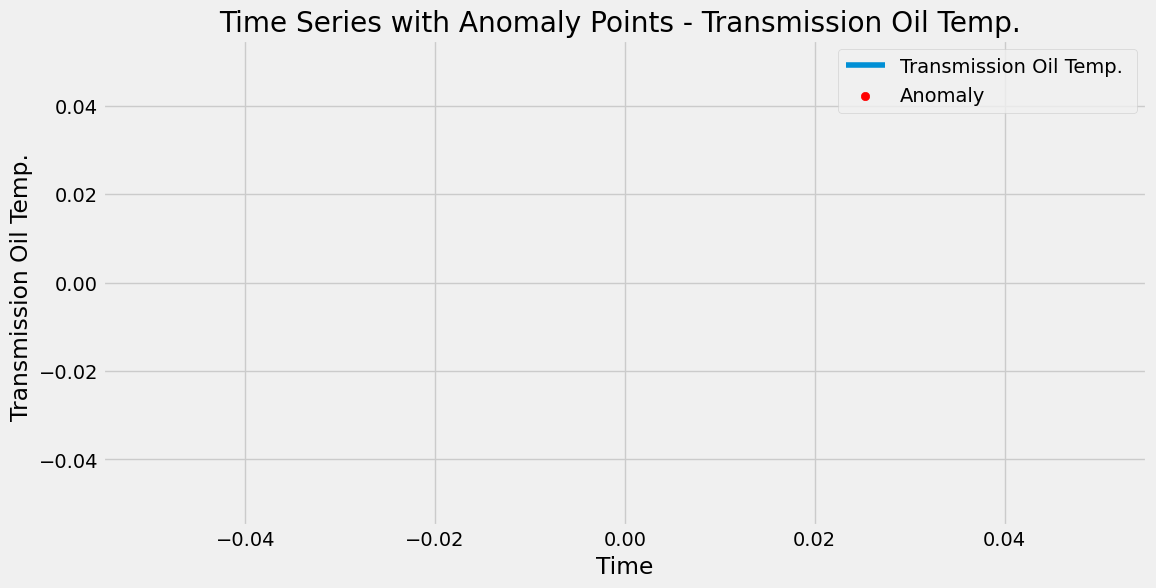

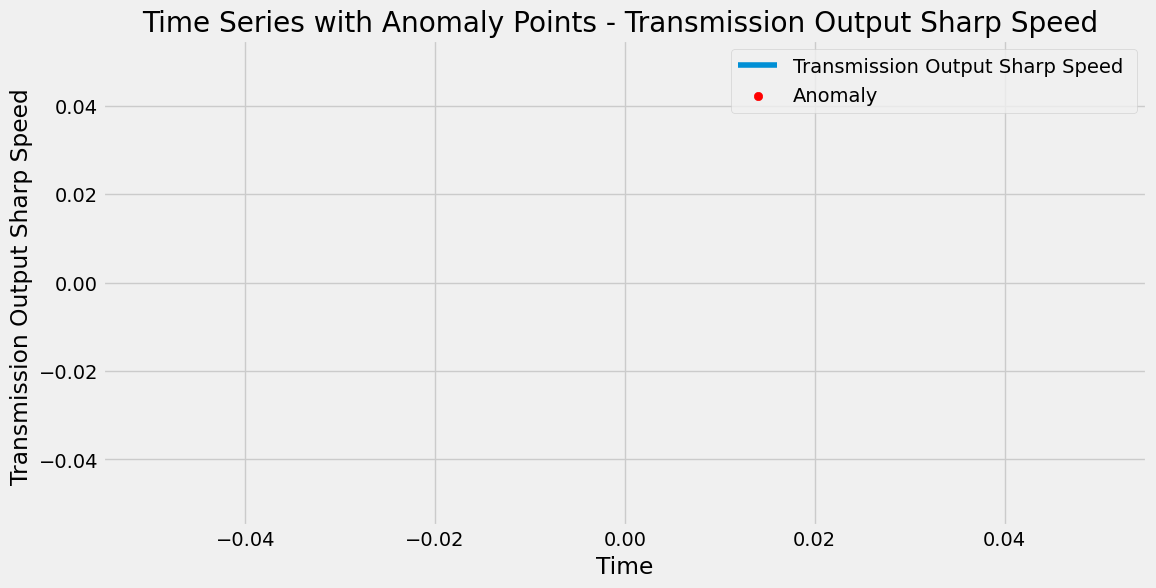

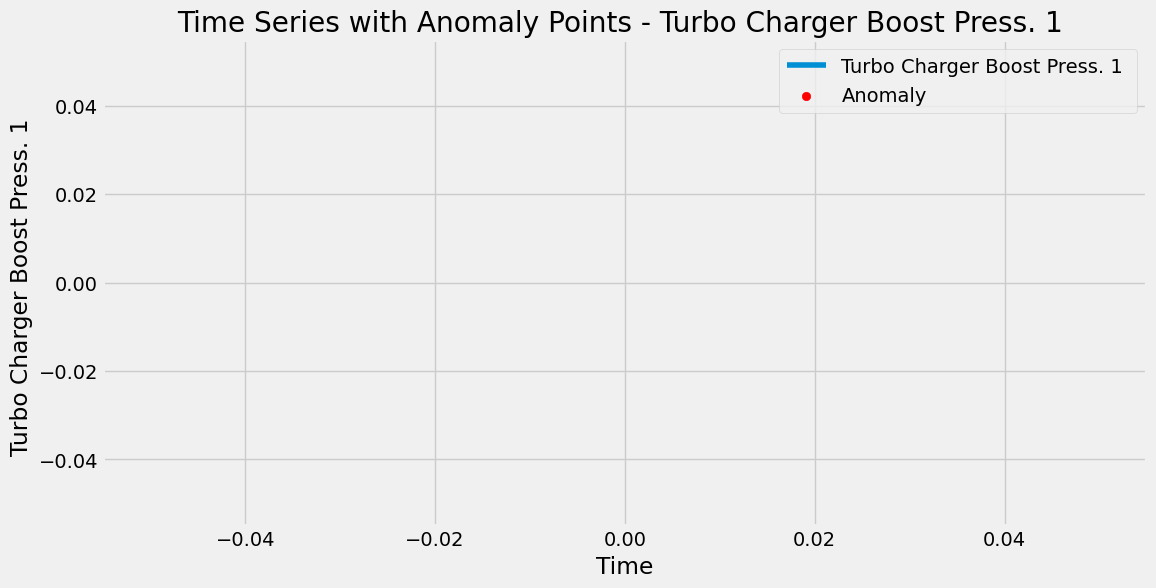

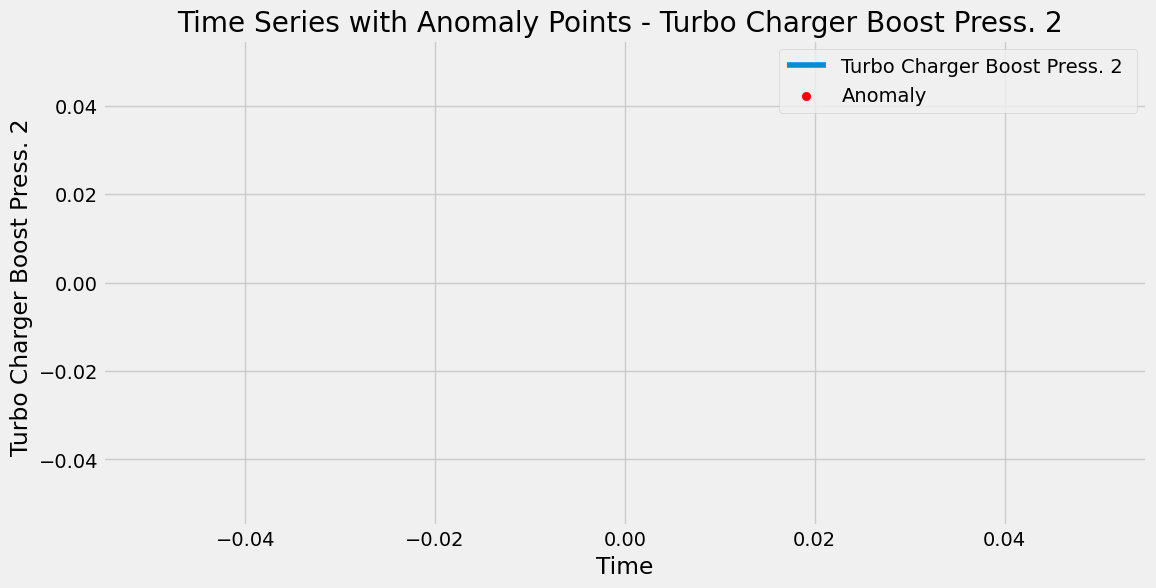

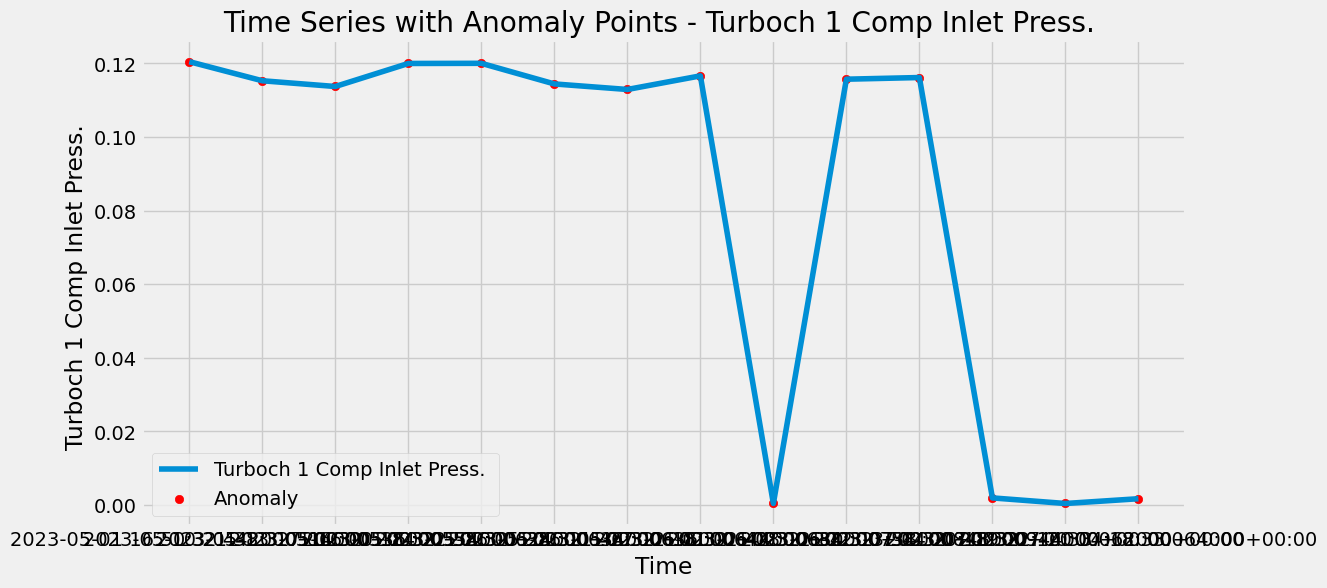

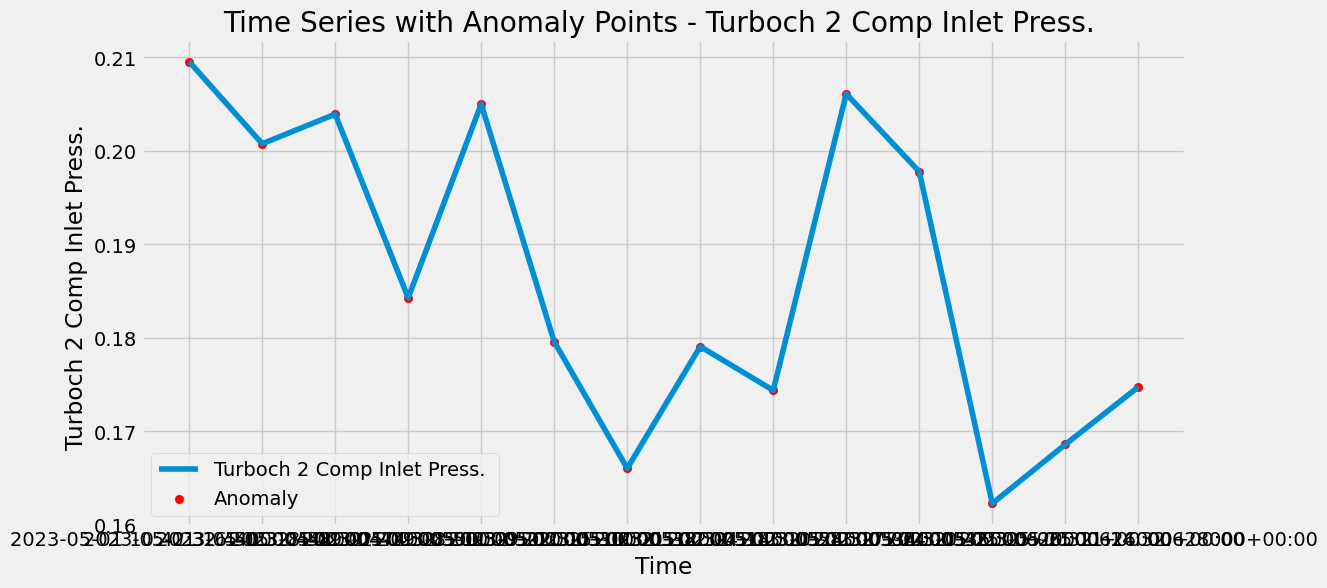

In [29]:
# plotting the anomalies and the data of all of the sensors
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import joblib

def detect_anomalies(sensor, df, contamination=0.04):
    desired_columns = ["_time", sensor, "hour"]
    df = df[desired_columns]

    model = IsolationForest(contamination=contamination)
    model.fit(df[[sensor]])

    predictions = model.predict(df[[sensor]])


    df['Anomaly'] = predictions

    return df[df['Anomaly'] == -1]


engine1 = '/content/modified_sb_main_engine.csv'
engine2 = '/content/modified_ps_main_engine.csv'


df1 = pd.read_csv(engine1)
df2 = pd.read_csv(engine2)

all_columns = df1.columns.tolist()
all_columns.remove("_time")
all_columns.remove("hour")


anomaly_points = {}


for sensor in all_columns:
    anomaly_points[sensor] = detect_anomalies(sensor, df1)

def plot_anomaly_points(sensor, df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['_time'], df[sensor], label=sensor)
    plt.scatter(df['_time'][df['Anomaly'] == -1], df[sensor][df['Anomaly'] == -1], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel(sensor)
    plt.title(f'Time Series with Anomaly Points - {sensor}')
    plt.legend()
    plt.show()

for sensor, anomalies in anomaly_points.items():
    plot_anomaly_points(sensor, anomalies)


Alert: Acc. Pedal Position value exceeds the threshold (20).


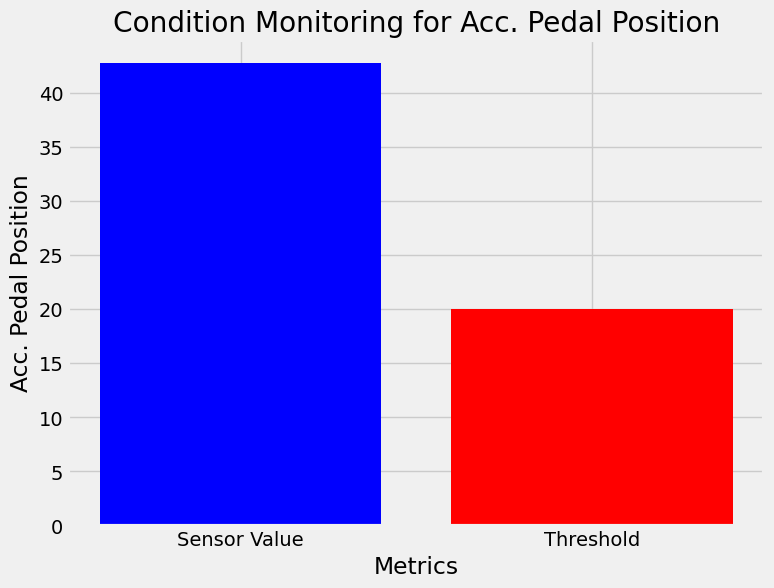

Alert: Air Filter Diff Press. value exceeds the threshold (0.3).


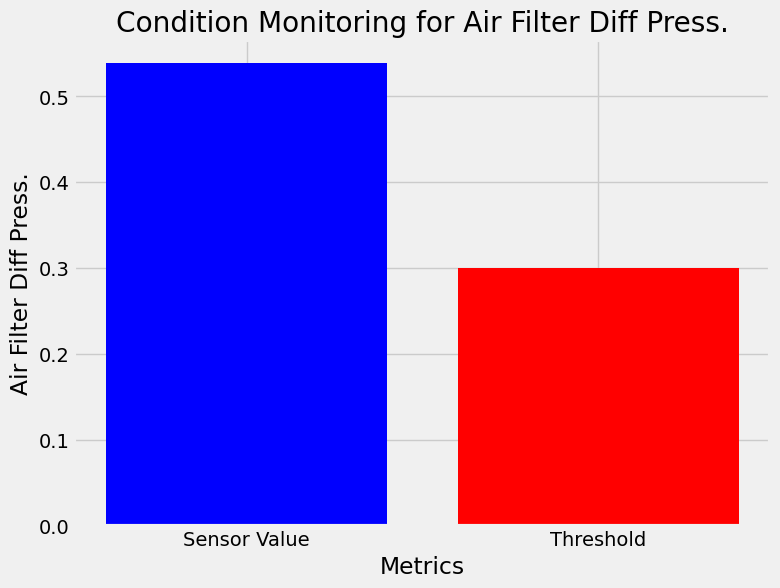

Air Inlet Press. is within the acceptable range.
No threshold defined for Auxiliary Press. 1. Please set a threshold.
No threshold defined for Barometric Press.. Please set a threshold.
Alert: Boost Press. value exceeds the threshold (30).


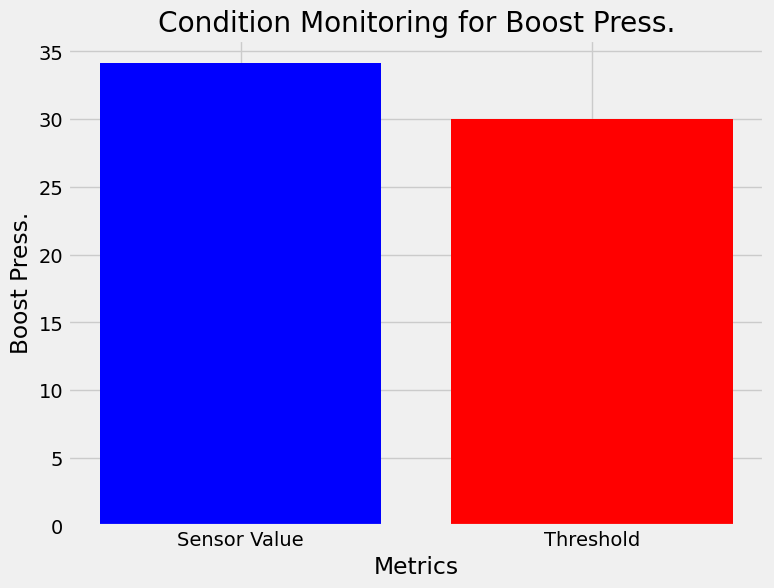

No threshold defined for Coolant Level. Please set a threshold.
No threshold defined for Coolant Press.. Please set a threshold.
Coolant Temp. is within the acceptable range.
No threshold defined for Crankcase Press. . Please set a threshold.
No threshold defined for Electrical Voltage. Please set a threshold.
No threshold defined for Eng. Aux Coolant Press.. Please set a threshold.
No threshold defined for Eng. Hours. Please set a threshold.
No threshold defined for Eng. Load. Please set a threshold.
No threshold defined for Eng. Oil Level . Please set a threshold.
No threshold defined for Eng. Oil Press. . Please set a threshold.
No threshold defined for Eng. Oil Temp. . Please set a threshold.
No threshold defined for Eng. Revolutions . Please set a threshold.
No threshold defined for Eng. Speed . Please set a threshold.
No threshold defined for Eng. Total Fuel Used . Please set a threshold.
No threshold defined for Eng. Trip Fuel . Please set a threshold.
No threshold defined for E

In [30]:
# Condition monitoring: the condition is based on a threshhold which is set according to the anomalies of the sennsors and for each sensor we can
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import joblib

def detect_anomalies(sensor, df, contamination=0.04):
    desired_columns = ["_time", sensor, "hour"]
    df = df[desired_columns]

    model = IsolationForest(contamination=contamination)
    model.fit(df[[sensor]])

    predictions = model.predict(df[[sensor]])

    df['Anomaly'] = predictions

    return df[df['Anomaly'] == -1]

engine1 = '/content/modified_sb_main_engine.csv'
engine2 = '/content/modified_ps_main_engine.csv'

df1 = pd.read_csv(engine1)
df2 = pd.read_csv(engine2)


all_columns = df1.columns.tolist()
all_columns.remove("_time")
all_columns.remove("hour")

anomaly_points = {}

for sensor in all_columns:
    anomaly_points[sensor] = detect_anomalies(sensor, df1)

# Add more thresholds/rules for other sensors as needed
thresholds = {
    'Acc. Pedal Position': 20,
    'Air Filter Diff Press.': 0.3,
    'Air Inlet Press.': 1.5,
    'Boost Press.': 30,
    'Coolant Temp.': 90,

}


def condition_monitoring(sensor, anomalies, thresholds):
    if sensor in thresholds:
        threshold_value = thresholds[sensor]
        max_value = anomalies[sensor].max()
        if max_value > threshold_value:
            print(f"Alert: {sensor} value exceeds the threshold ({threshold_value}).")

            plt.figure(figsize=(8, 6))
            plt.bar(['Sensor Value', 'Threshold'], [max_value, threshold_value], color=['blue', 'red'])
            plt.xlabel('Metrics')
            plt.ylabel(sensor)
            plt.title(f'Condition Monitoring for {sensor}')
            plt.show()
        else:
            print(f"{sensor} is within the acceptable range.")
    else:
        print(f"No threshold defined for {sensor}. Please set a threshold.")

for sensor, anomalies in anomaly_points.items():
    condition_monitoring(sensor, anomalies, thresholds)
